# Search: Solving a Maze Using a Goal-based Agent

## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planning exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [36]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2637, done.
remote: Counting objects: 100% (754/754), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 2637 (delta 465), reused 698 (delta 421), pack-reused 1883
Receiving objects: 100% (2637/2637), 284.88 MiB | 37.60 MiB/s, done.
Resolving deltas: 100% (1633/1633), done.
/content/CS7320-AI/Search/CS7320-AI/Search/CS7320-AI/Search
empty_2_maze.txt	  loops_maze.txt		     maze_helper.py   small_maze.txt
empty_maze.txt		  Maze_BFS_vs_A_Star.ipynb	     Maze.ipynb       wall_maze.txt
Explore_heuristics.ipynb  Maze_Example-Animation_full.ipynb  medium_maze.txt
large_maze.txt		  Maze_Example-Animation.ipynb	     open_maze.txt
L_maze.txt		  Maze_Example.ipynb		     README.md


In [37]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [38]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

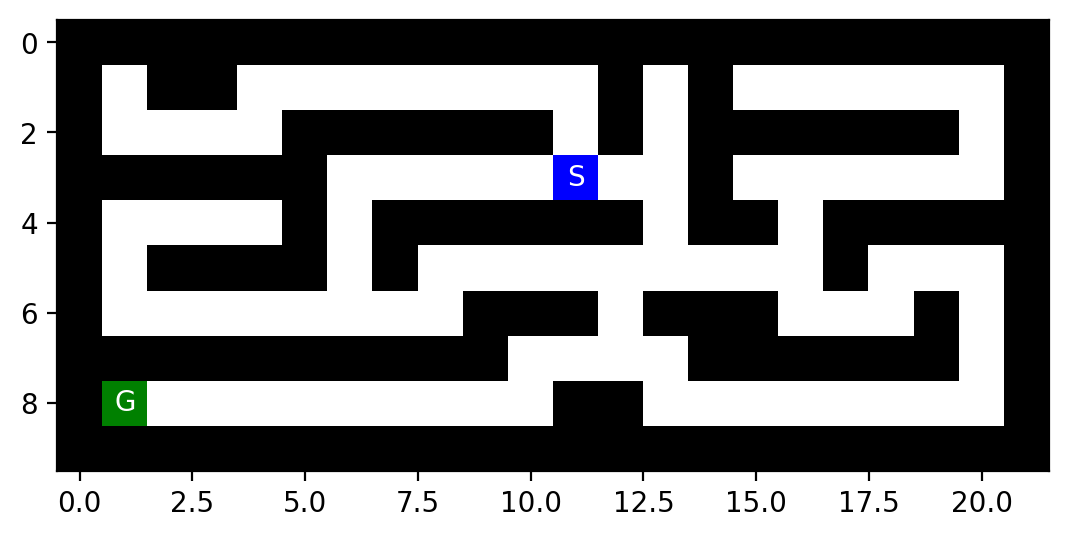

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [40]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [41]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [42]:
class Node:
    def __init__(self, pos, parent, action, cost, heuristic, astar=False):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.heuristic = heuristic     # heuristic value (Manhattan distance)
        self.f = cost + heuristic      # f(n) for A* search algorithm
        self.astar = astar             # whether this node is generated in an A* search algorithm

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    # less than method for comparison of nodes in priority queue
    def __lt__(self, other):
      # if the nodes were generated in an A* search algorithm, compare their f values
      if self.astar and other.astar:
        return self.f < other.f
      # else, compare their heuristic values
      return self.heuristic < other.heuristic

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [43]:
# Initial state: the square/position with the "S" character
# Actions: move up, down, left, or right into an empty square/position
# Transition model: up decreases the row number, down increases the row number,
#                   left decreases the column number, right increases the column number
# Goal state: the square/position with the "G" character
# Path cost: depth of the square/position in the search tree

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determine these values for a given maze.

In [44]:
# state space size (n): the number of empty squares, as well as the start and goal squares (determined by counting them in the maze)
# depth of the optimal solution (d): the number of squares in the optimal path (determined by finding the length of the path found by a search algorithm)
# maximum depth of tree (m): the number of squares in the longest path (determined by keeping track of the largest depth reached)
# maximum branching factor (b): at most four, one for each direction (determined by finding the empty square with the most adjacent empty squares in the maze)

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

{'solution': <__main__.Node object at 0x7c8e441e0a90>, 'path_cost': 19, 'num_expanded': 90, 'max_depth': 19, 'max_memory': 91, 'max_frontier': 8}


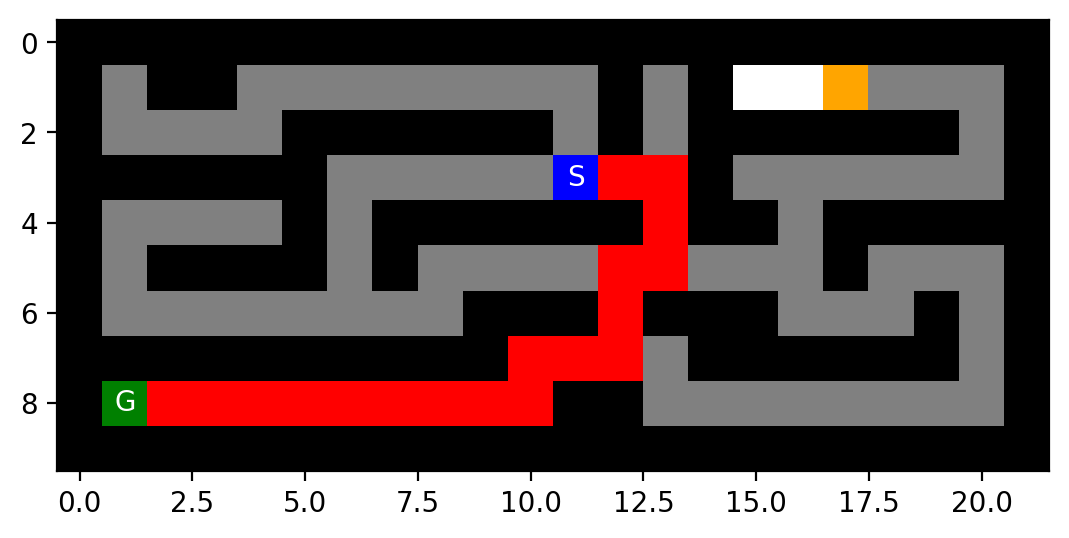

{'solution': <__main__.Node object at 0x7c8e440383a0>, 'path_cost': 37, 'num_expanded': 37, 'max_depth': 37, 'max_memory': 7, 'max_frontier': 7}


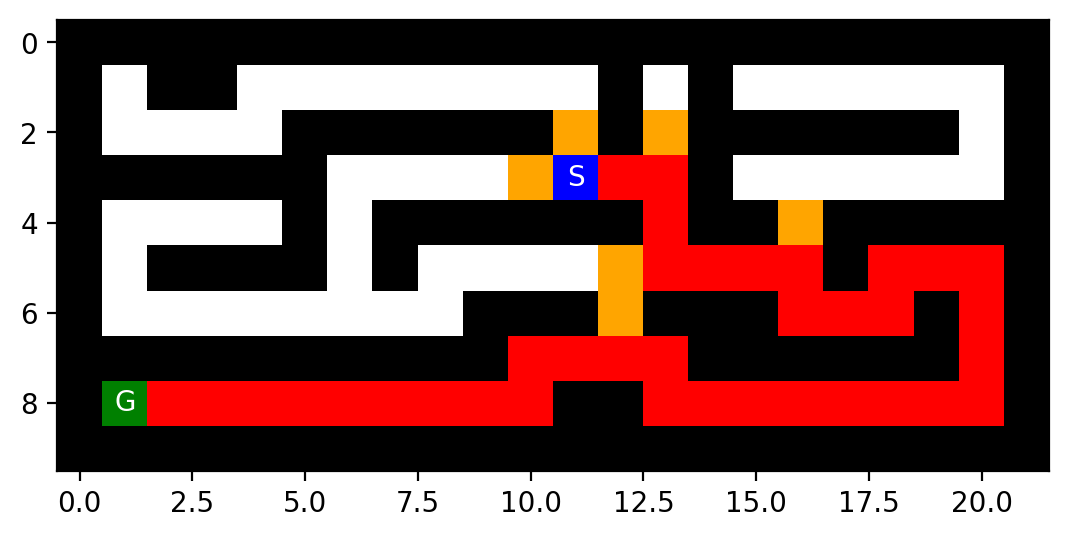

In [45]:
from collections import deque

def heuristic(pos, goal):
  # return Manhattan distance from pos to goal
  return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

def expand(maze, node, goal, astar=False):
  row, col = node.pos
  children = []

  # generate node if going up is within the boundaries of the maze and is not a wall square
  if row - 1 >= 0 and maze[row - 1, col] != "X":
    children.append(Node((row - 1, col), node, "up", node.cost + 1, heuristic((row - 1, col), goal), astar=astar))

  # generate node if going down is within the boundaries of the maze and is not a wall square
  if row + 1 < maze.shape[0] and maze[row + 1, col] != "X":
    children.append(Node((row + 1, col), node, "down", node.cost + 1, heuristic((row + 1, col), goal), astar=astar))

  # generate node if going left is within the boundaries of the maze and is not a wall square
  if col - 1 >= 0 and maze[row, col - 1] != "X":
    children.append(Node((row, col - 1), node, "left", node.cost + 1, heuristic((row, col - 1), goal), astar=astar))

  # generate node if going right is within the boundaries of the maze and is not a wall square
  if col + 1 < maze.shape[1] and maze[row, col + 1] != "X":
    children.append(Node((row, col + 1), node, "right", node.cost + 1, heuristic((row, col + 1), goal), astar=astar))

  return children

def breadth_first_search(maze):
  # find start and goal positions
  start = mh.find_pos(maze, what="S")
  goal = mh.find_pos(maze, what="G")

  # generate node for start position and check if it is also the goal position
  node = Node(start, None, None, 0, heuristic(start, goal))
  if node.pos == goal:
    return node

  # intitialize frontier and reached data structures, as well as statistic variables
  frontier = deque([node])
  reached = {start}
  num_expanded = 0
  max_depth = 0
  max_frontier = len(frontier)

  # loop until frontier is empty
  while len(frontier) > 0:
    # pop node and update statistics variables
    node = frontier.popleft()
    num_expanded += 1
    max_depth = max(max_depth, node.cost + 1)

    # expand node and iterate over children
    for child in expand(maze, node, goal):
      # if child position is the goal position, mark on the maze the frontier and path
      if child.pos == goal:
        for i in frontier:
          row, col = i.pos
          if maze[row, col] != "S" and maze[row, col] != "G":
            maze[row, col] = "F"
        for i in child.get_path_from_root():
          row, col = i.pos
          if maze[row, col] != "S" and maze[row, col] != "G":
            maze[row, col] = "P"
        # return the solution and statistic variables as a dictionary
        return {"solution": child, "path_cost": child.cost, "num_expanded": num_expanded, "max_depth": max_depth, "max_memory": len(reached), "max_frontier": max_frontier}

      # if child position has not been reached, add it to reached and frontier, mark on the maze the child position as visited, and update a statistic variable
      if child.pos not in reached:
        reached.add(child.pos)
        frontier.append(child)
        row, col = child.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "."
        max_frontier = max(max_frontier, len(frontier))

  # return None if no solution is found
  return None

def depth_first_search(maze):
  # find start and goal positions
  start = mh.find_pos(maze, what="S")
  goal = mh.find_pos(maze, what="G")

  # generate node for start position and check if it is also the goal position
  node = Node(start, None, None, 0, heuristic(start, goal))
  if node.pos == goal:
    return node

  # intitialize frontier data structure, as well as statistic variables
  frontier = deque([node])
  num_expanded = 0
  max_depth = 0
  max_frontier = len(frontier)

  # loop until frontier is empty
  while len(frontier) > 0:
    # pop node and update statistics variables
    node = frontier.pop()
    num_expanded += 1
    max_depth = max(max_depth, node.cost + 1)

    # expand node and iterate over children
    for child in expand(maze, node, goal):
      # if child position is the goal position, mark on the maze the frontier and path
      if child.pos == goal:
        for i in frontier:
          row, col = i.pos
          if maze[row, col] != "S" and maze[row, col] != "G":
            maze[row, col] = "F"
        for i in child.get_path_from_root():
          row, col = i.pos
          if maze[row, col] != "S" and maze[row, col] != "G":
            maze[row, col] = "P"
        # return the solution and statistic variables as a dictionary
        return {"solution": child, "path_cost": child.cost, "num_expanded": num_expanded, "max_depth": max_depth, "max_memory": max_frontier, "max_frontier": max_frontier}

      # check for a cycle by going up the search tree until the source node
      # if a node is found matching the child's position, there is a cycle
      temp = child.parent
      cycle = False
      while temp != None:
        if temp.pos == child.pos:
          cycle = True
          break
        temp = temp.parent

      # if there is not a cycle, add child to frontier, mark on the maze the child position as visited, and update a statistic variable
      if not cycle:
        frontier.append(child)
        row, col = child.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "."
        max_frontier = max(max_frontier, len(frontier))

  # return None if no solution is found
  return None

maze = mh.parse_maze(maze_str)
print(breadth_first_search(maze))
mh.show_maze(maze)

maze = mh.parse_maze(maze_str)
print(depth_first_search(maze))
mh.show_maze(maze)

How does BFS and DFS deal with loops (cycles)?

In [46]:
# BFS maintains a reached data structure that stores which nodes have been added to the frontier already,
# so it knows which nodes not to expand again

# Without any cycle checking, DFS will go into an infinite loop when it reaches a cycle in the search tree
# My implementation includes cycle checking, which goes up the search tree until the source node,
# and if a node is found matching the child's position, there is a cycle
# That node will not be added to the frontier

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [47]:
# My BFS implementation is complete, because a solution will be found eventually if it exists as the depth of the solution is finite
# It is optimal, because depth is equal to path cost as costs are all one and it will incrementally reach deeper nodes
# Time complexity: O(b^s), where b is the branching factor and s is the depth of the shallowest solution
#                  (number of nodes reached is O(b^s))
# Space complexity: O(b^s), where b is the branching factor and s is the depth of the shallowest solution
#                   (number of nodes in reached and frontier data structures is both O(b^s))

# My DFS implementation is not complete, because it can still run into a cycle and continue infinitely, as well as go down an infinite state space forever
# It is not optimal, because it returns the first solution it finds, which may not be optimal
# Time complexity: O(m*(b^m)), where m is the maximum depth of the tree and b is the branching factor
#                  (base DFS is O(b^m) because it can generate every node in the search tree and cycle checking for each node is O(m)
#                   because the path from the node to the source node is O(m) length)
# Space complexity: O(bm), where m is the maximum depth of the tree and b is the branching factor
#                   (frontier only contains siblings on the path from the source node)

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

{'solution': <__main__.Node object at 0x7c8e441e2aa0>, 'path_cost': 29, 'num_expanded': 40, 'max_depth': 30, 'max_memory': 44, 'max_frontier': 5}


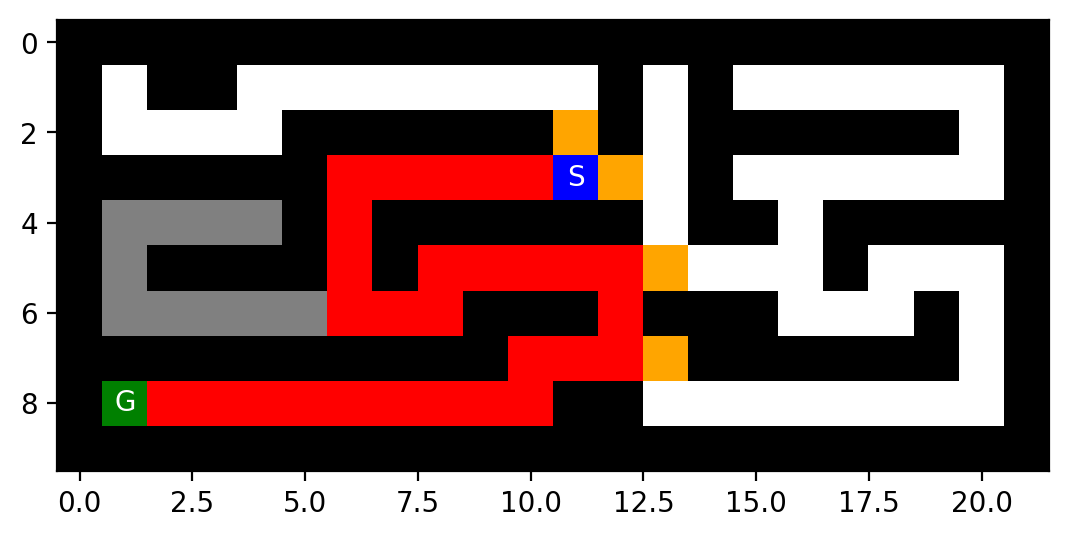

{'solution': <__main__.Node object at 0x7c8e357e8df0>, 'path_cost': 19, 'num_expanded': 53, 'max_depth': 20, 'max_memory': 59, 'max_frontier': 8}


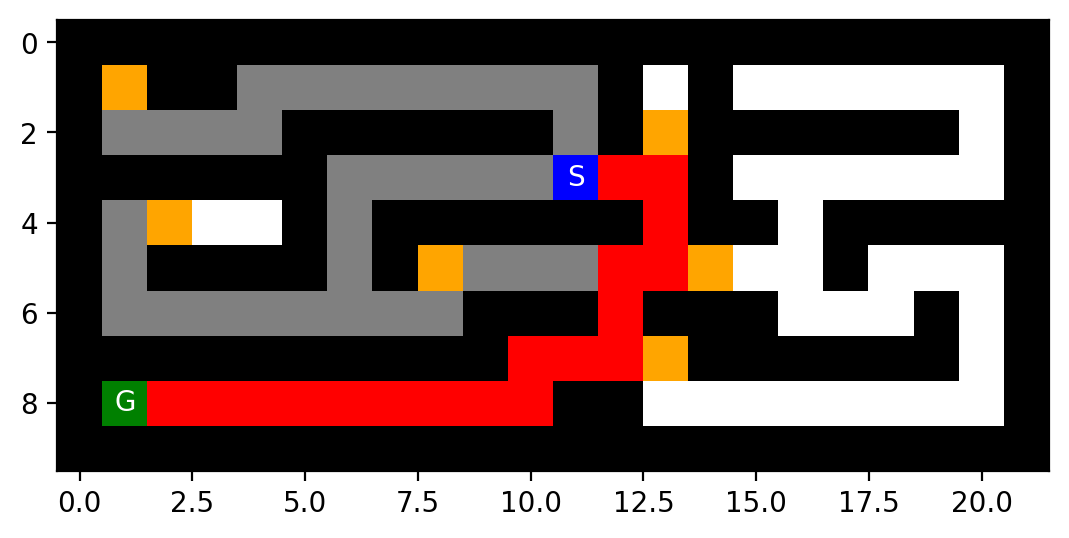

In [48]:
import heapq

def greedy_best_first_search(maze):
  # find start and goal positions
  start = mh.find_pos(maze, what="S")
  goal = mh.find_pos(maze, what="G")

  # generate node for start position and check if it is also the goal position
  node = Node(start, None, None, 0, heuristic(start, goal))
  if node.pos == goal:
    return node

  # intitialize frontier and reached data structures, as well as statistic variables
  frontier = [node]
  reached = {start}
  num_expanded = 0
  max_depth = 0
  max_frontier = len(frontier)

  # loop until frontier is empty
  while len(frontier) > 0:
    # pop node and update statistics variables
    node = heapq.heappop(frontier)
    num_expanded += 1
    max_depth = max(max_depth, node.cost + 1)

    # if node position is the goal position, mark on the maze the frontier and path
    if node.pos == goal:
      for i in frontier:
        row, col = i.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "F"
      for i in node.get_path_from_root():
        row, col = i.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "P"
      # return the solution and statistic variables as a dictionary
      return {"solution": node, "path_cost": node.cost, "num_expanded": num_expanded, "max_depth": max_depth, "max_memory": len(reached), "max_frontier": max_frontier}

    # expand node and iterate over children
    for child in expand(maze, node, goal):
      # if child position has not been reached, add it to reached and frontier, mark on the maze the child position as visited, and update a statistic variable
      if child.pos not in reached:
        reached.add(child.pos)
        heapq.heappush(frontier, child)
        row, col = child.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "."
        max_frontier = max(max_frontier, len(frontier))

  # return None if no solution is found
  return None

def a_star_search(maze):
  # find start and goal positions
  start = mh.find_pos(maze, what="S")
  goal = mh.find_pos(maze, what="G")

  # generate node for start position and check if it is also the goal position
  node = Node(start, None, None, 0, heuristic(start, goal), astar=True)
  if node.pos == goal:
    return node

  # intitialize frontier and reached data structures, as well as statistic variables
  frontier = [node]
  reached = {start}
  num_expanded = 0
  max_depth = 0
  max_frontier = len(frontier)

  # loop until frontier is empty
  while len(frontier) > 0:
    # pop node and update statistics variables
    node = heapq.heappop(frontier)
    num_expanded += 1
    max_depth = max(max_depth, node.cost + 1)

    # if node position is the goal position, mark on the maze the frontier and path
    if node.pos == goal:
      for i in frontier:
        row, col = i.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "F"
      for i in node.get_path_from_root():
        row, col = i.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "P"
      # return the solution and statistic variables as a dictionary
      return {"solution": node, "path_cost": node.cost, "num_expanded": num_expanded, "max_depth": max_depth, "max_memory": len(reached), "max_frontier": max_frontier}

    # expand node and iterate over children
    for child in expand(maze, node, goal, astar=True):
      # if child position has not been reached, add it to reached and frontier, mark on the maze the child position as visited, and update a statistic variable
      if child.pos not in reached:
        reached.add(child.pos)
        heapq.heappush(frontier, child)
        row, col = child.pos
        if maze[row, col] != "S" and maze[row, col] != "G":
          maze[row, col] = "."
        max_frontier = max(max_frontier, len(frontier))

  # return None if no solution is found
  return None

maze = mh.parse_maze(maze_str)
print(greedy_best_first_search(maze))
mh.show_maze(maze)

maze = mh.parse_maze(maze_str)
print(a_star_search(maze))
mh.show_maze(maze)

Are your implementations complete and optimal? What is the time and space complexity?

In [49]:
# My GBS implementation is complete in finite state spaces, because it will avoid cycles by
# not expanding nodes it has stored as reached and will eventually find a solution
# It is not complete in infinite state spaces, because it can go down the search tree forever
# It is not optimal, because it returns the first solution it finds, which may not be optimal
# Time complexity: O(b^m), where m is the maximum depth of the tree and b is the branching factor
#                  (GBS can generate every node in the search tree)
# Space complexity: O(b^m), where m is the maximum depth of the tree and b is the branching factor
#                   (GBS can store every node in the search tree in memory)

# My A* implementation is complete, because it will avoid cycles by not expanding nodes it has
# stored as reached and will eventually find a solution
# It is optimal, because Manhattan distance is a admissable and consistent heuristic
# (h(A) <= cost(A, G) and h(A) - h(B) <= cost(A, B) are always true for any states A and B)
# Time complexity: O(b^m), where m is the maximum depth of the tree and b is the branching factor
#                  (A* can generate every node in the search tree)
# Space complexity: O(b^m), where m is the maximum depth of the tree and b is the branching factor
#                   (A* can store every node in the search tree in memory)

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

small_maze.txt
BFS


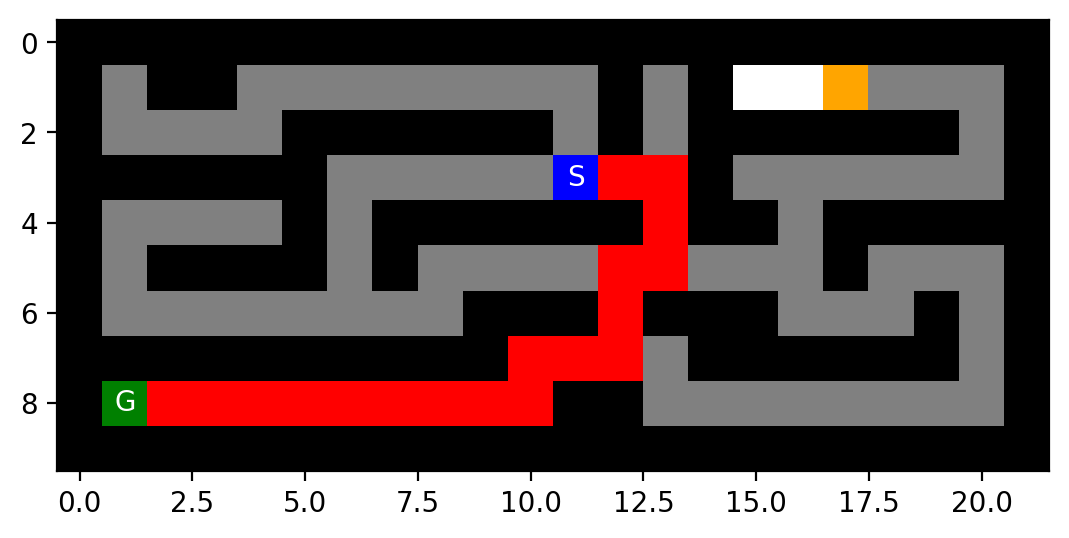



small_maze.txt
DFS


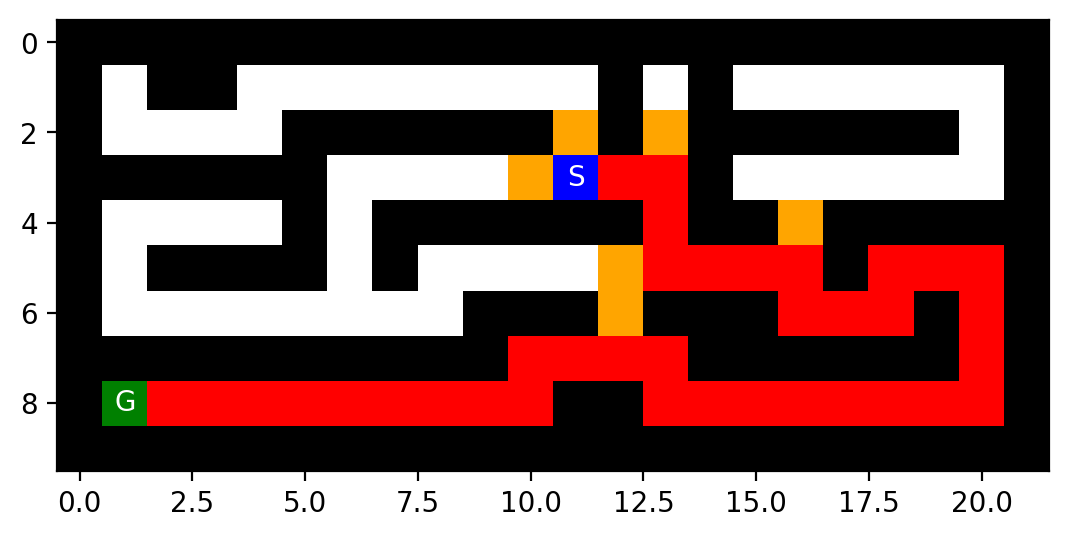



small_maze.txt
GBS


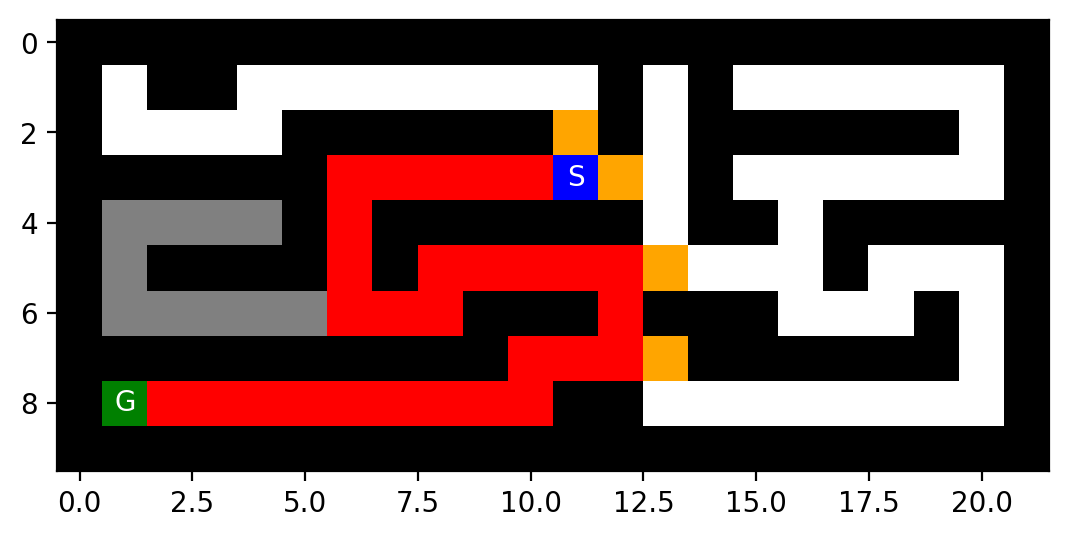



small_maze.txt
A*


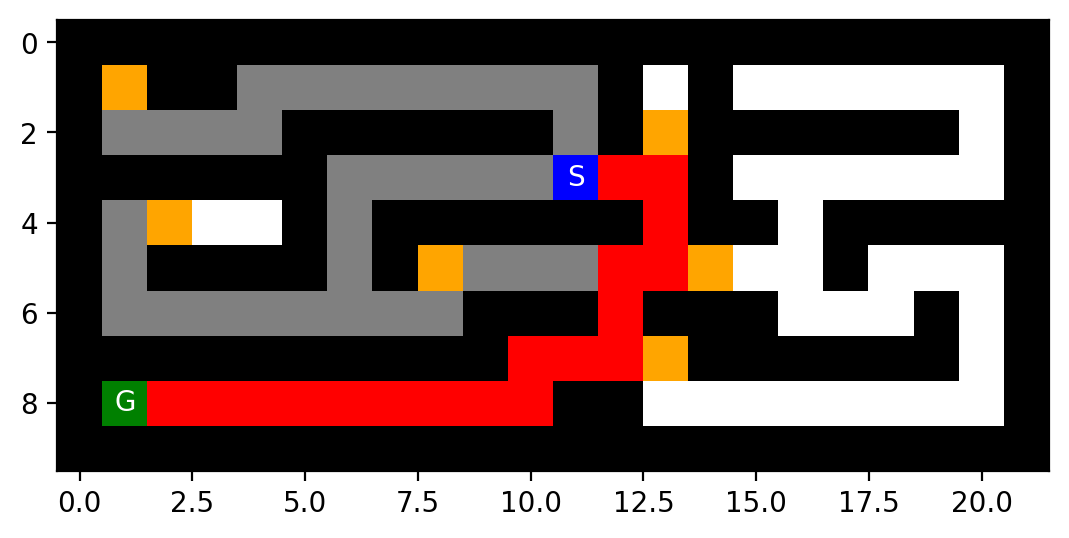



medium_maze.txt
BFS


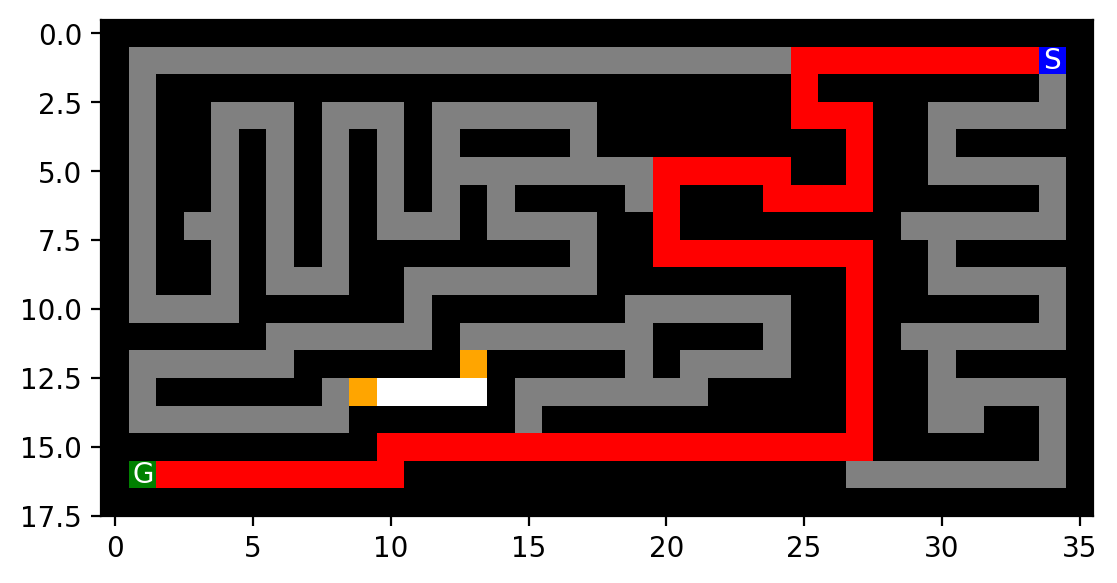



medium_maze.txt
DFS


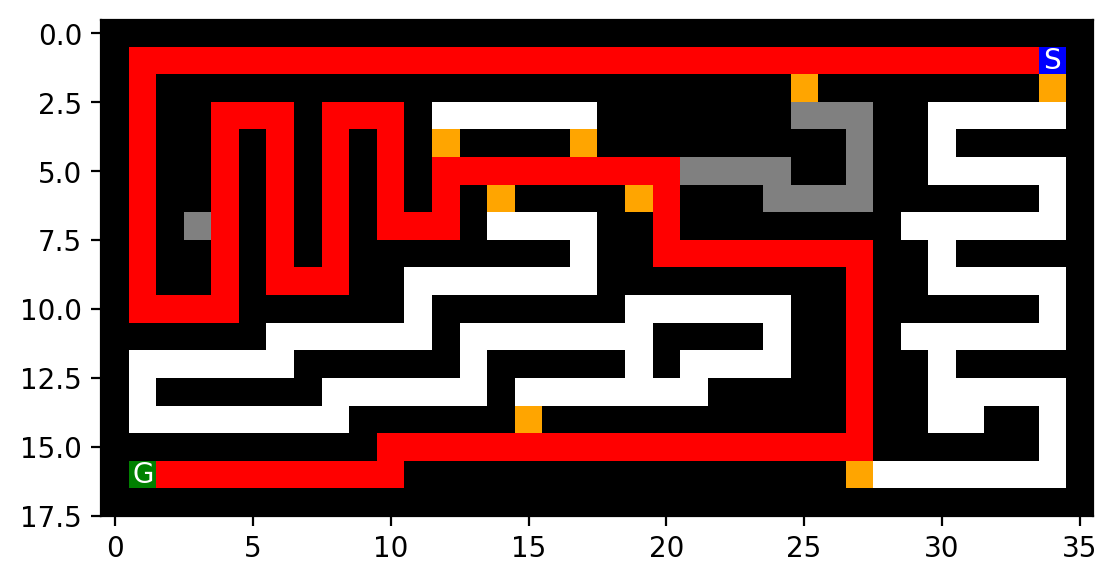



medium_maze.txt
GBS


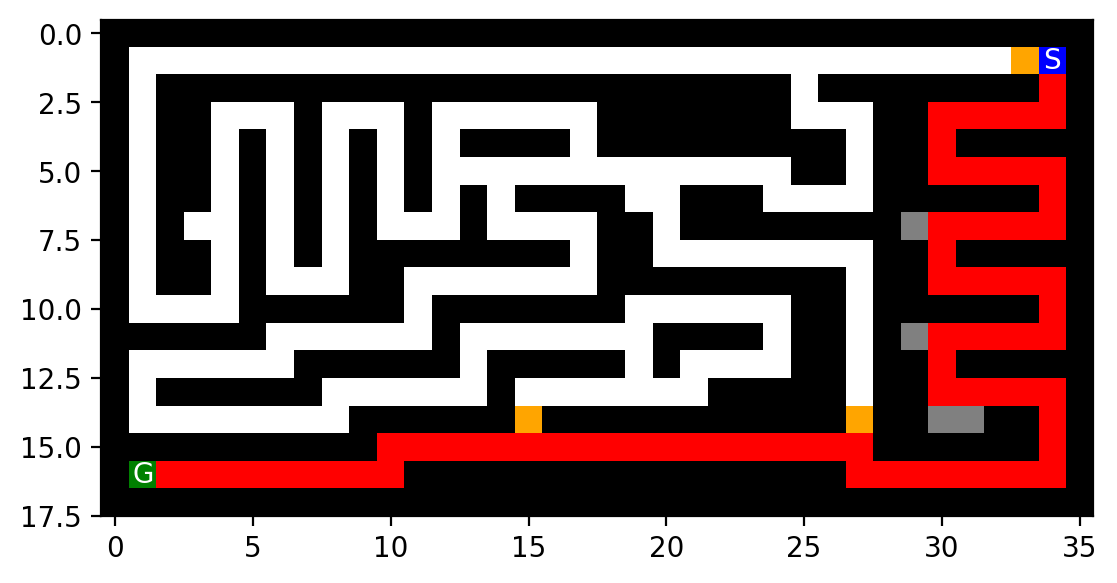



medium_maze.txt
A*


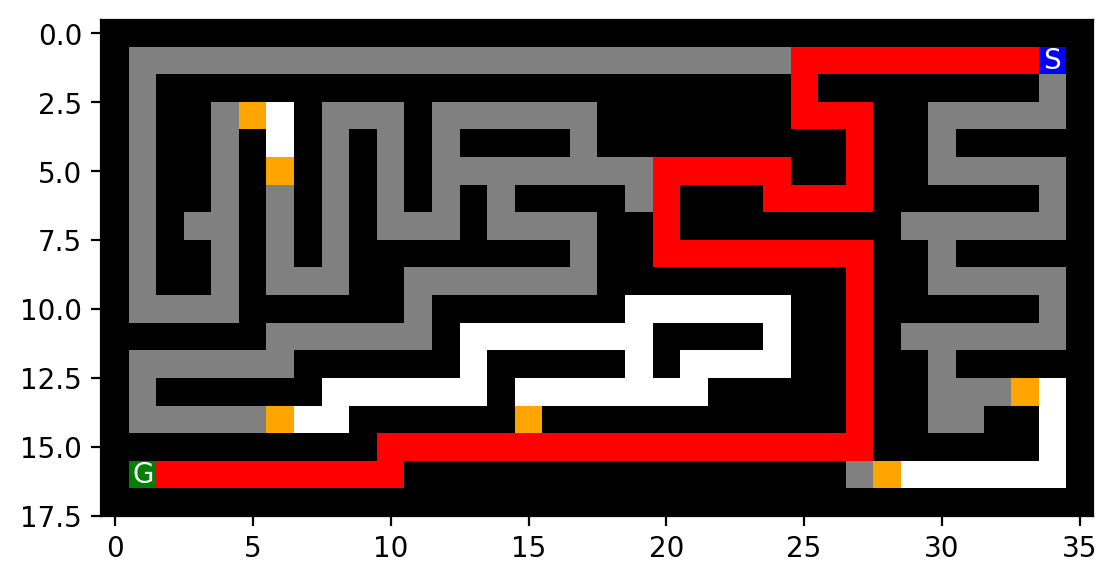



large_maze.txt
BFS


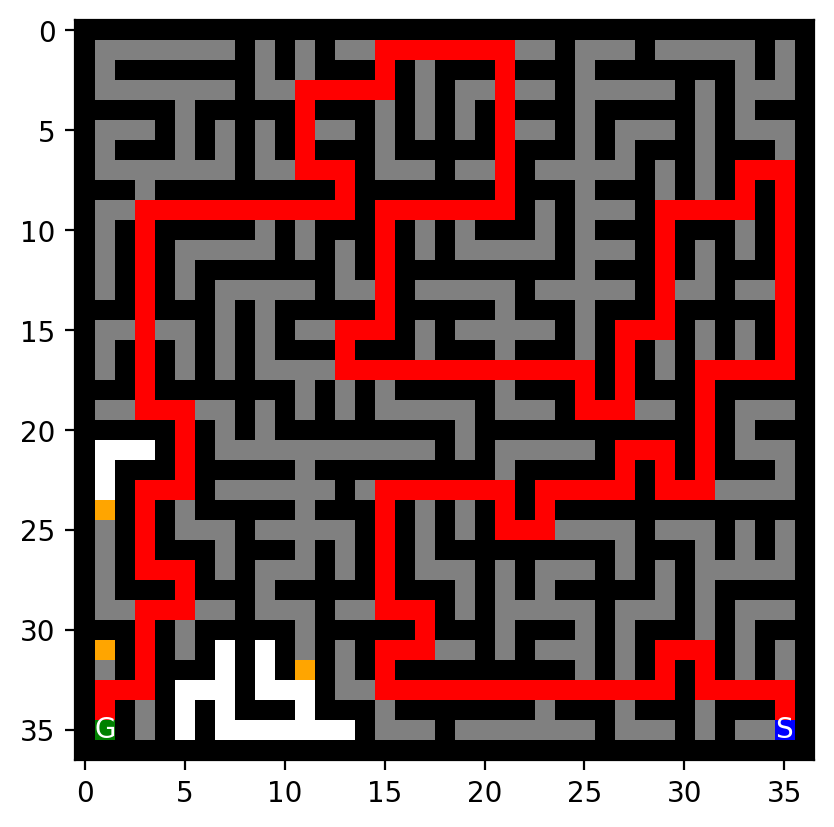



large_maze.txt
DFS


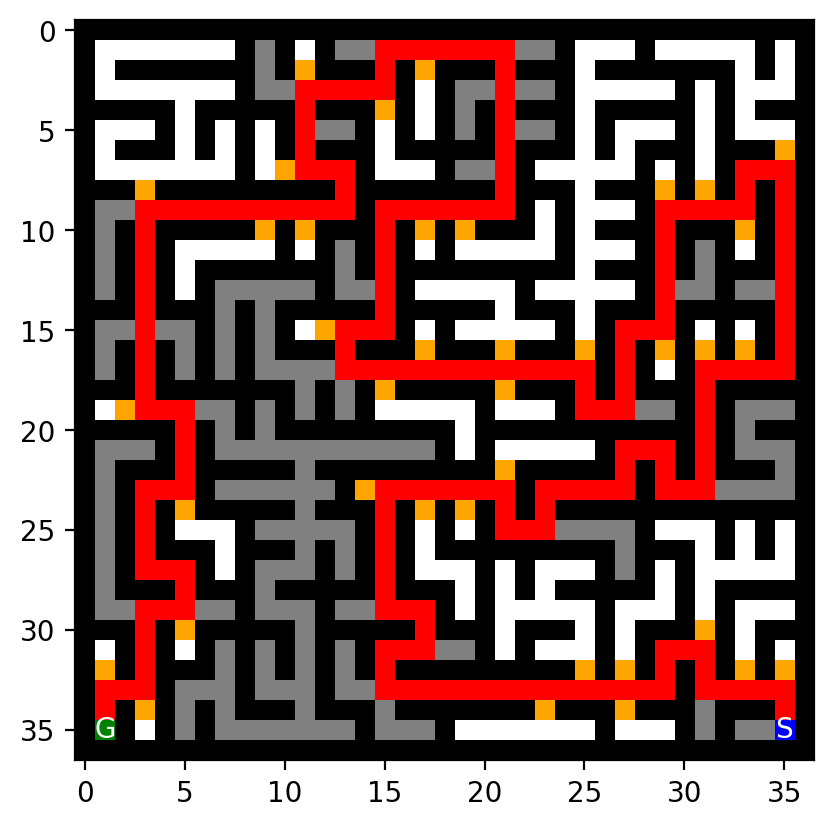



large_maze.txt
GBS


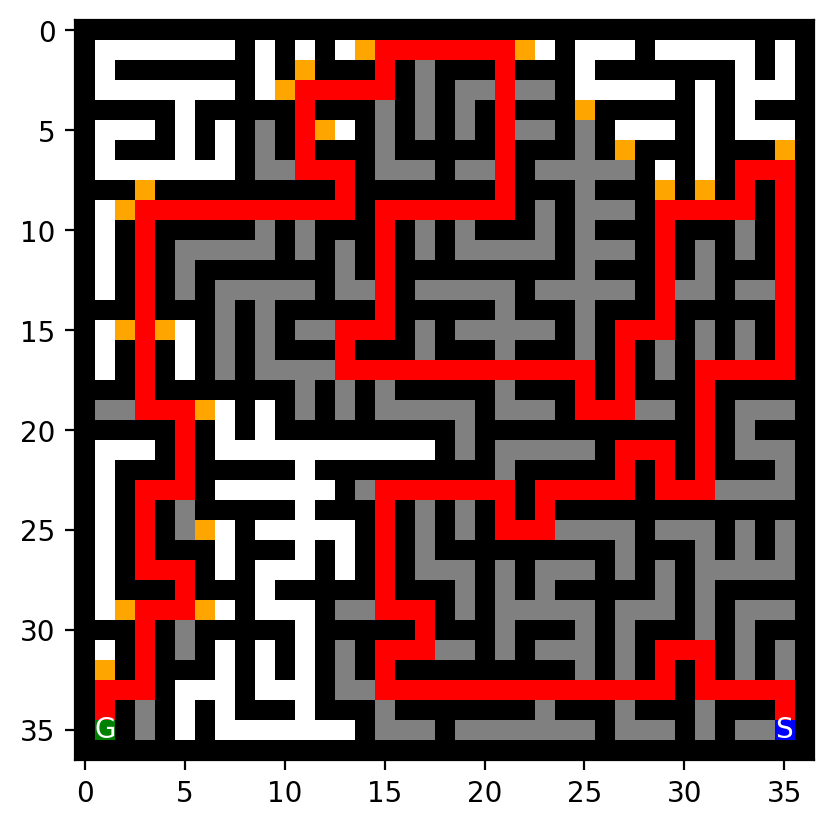



large_maze.txt
A*


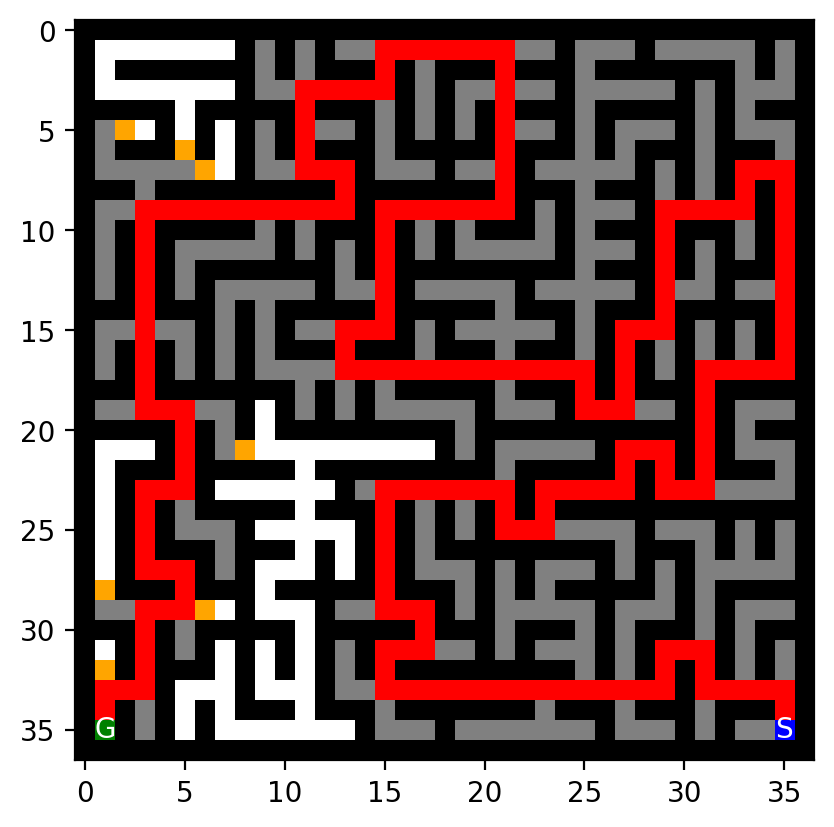



open_maze.txt
BFS


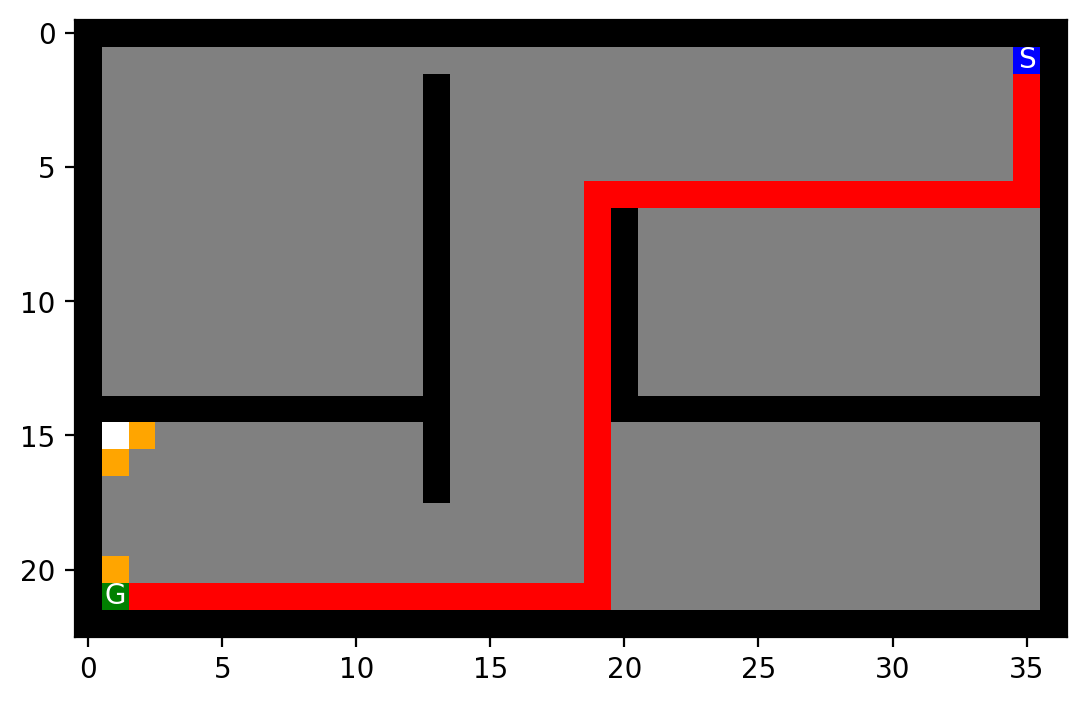



open_maze.txt
DFS


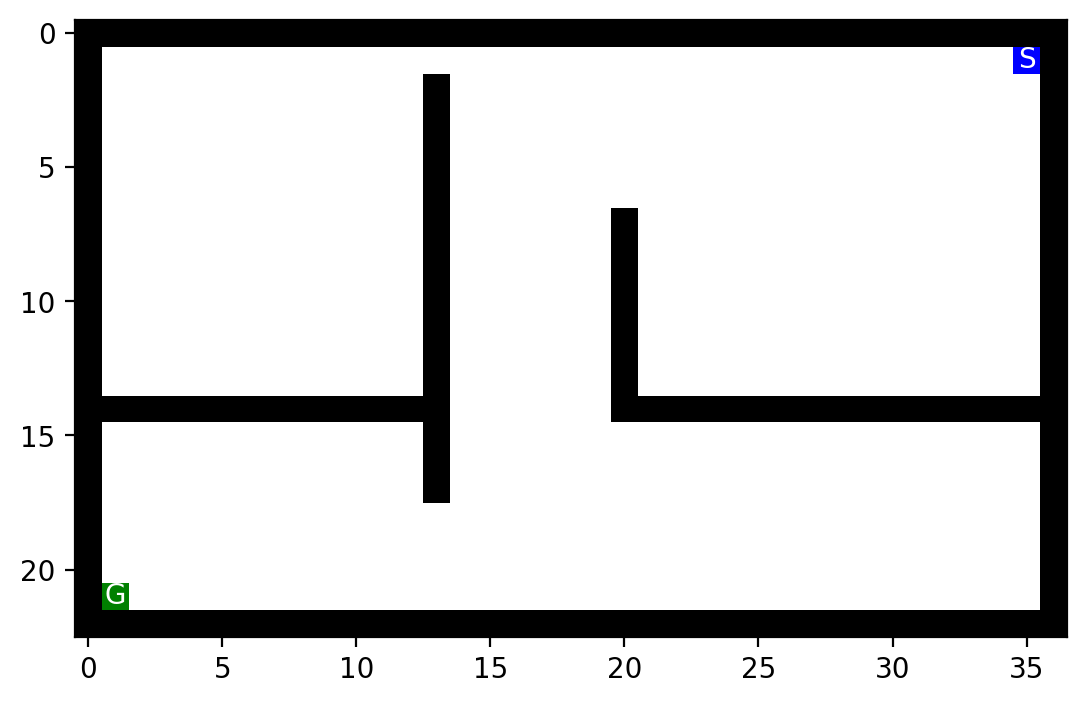



open_maze.txt
GBS


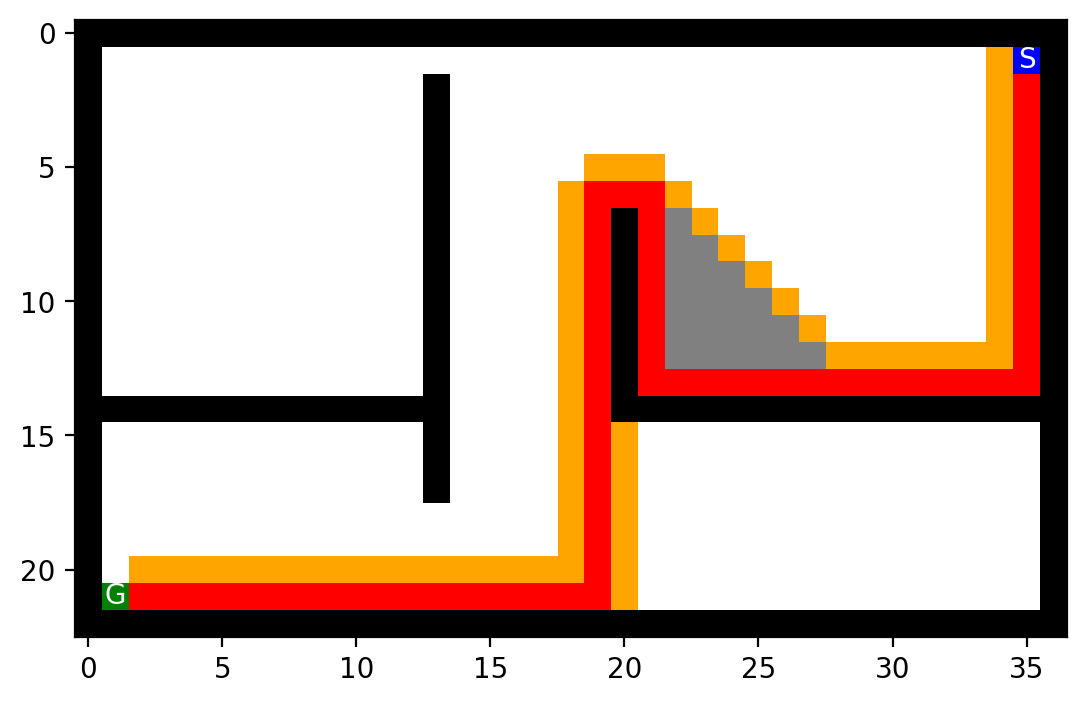



open_maze.txt
A*


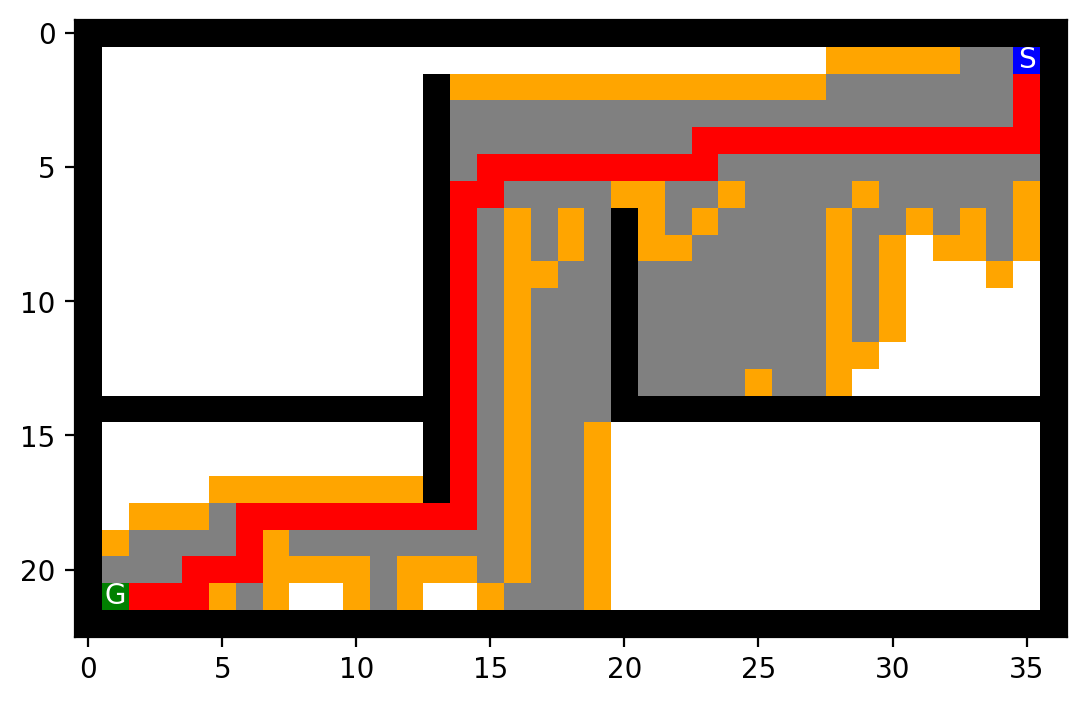



wall_maze.txt
BFS


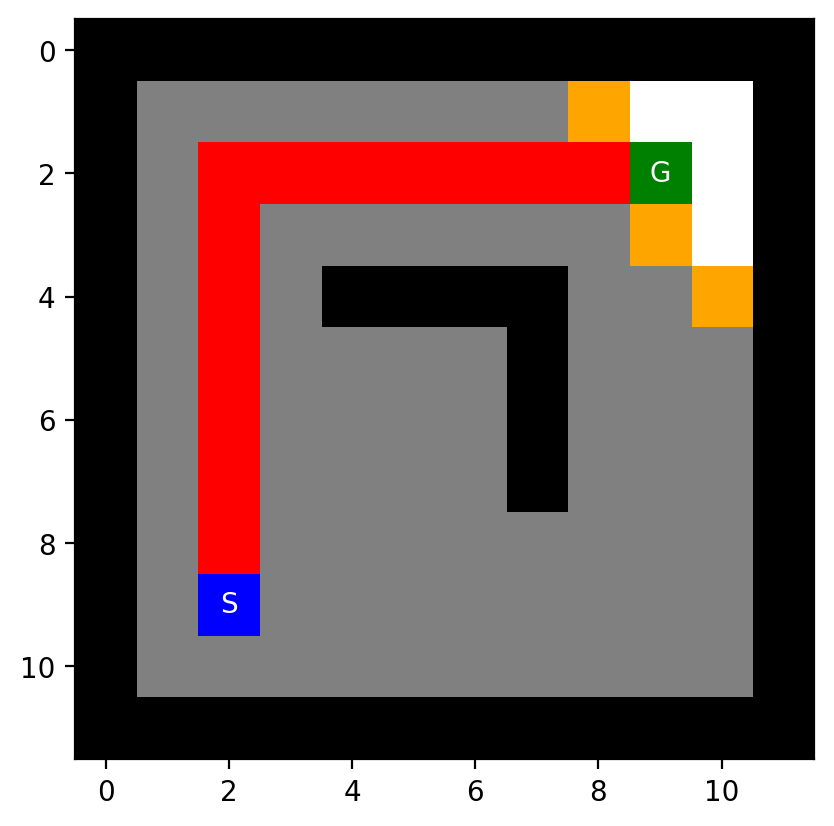



wall_maze.txt
DFS


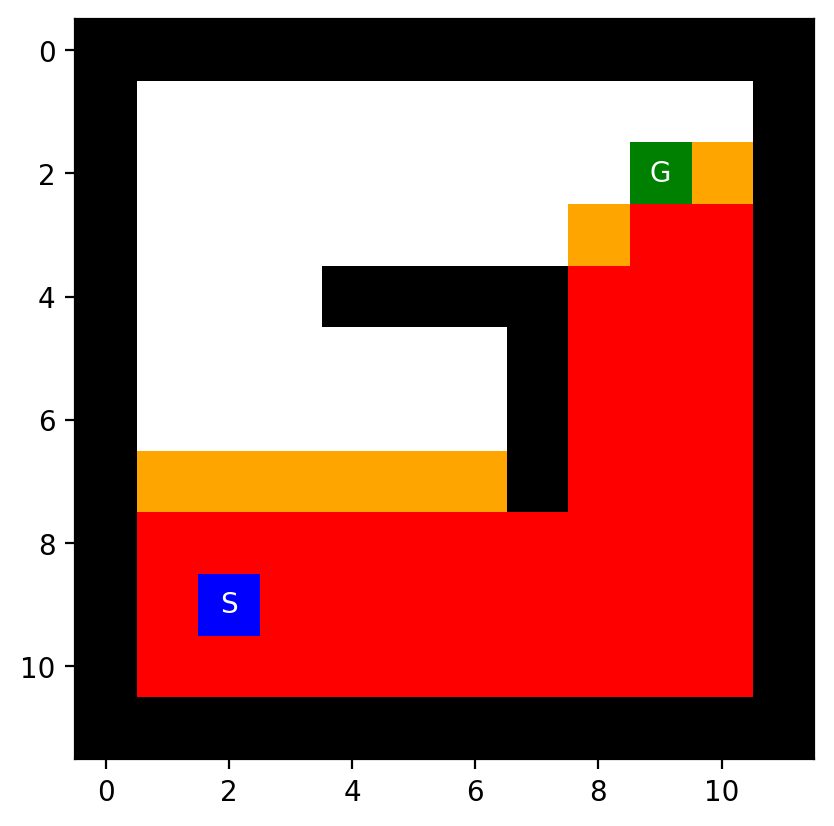



wall_maze.txt
GBS


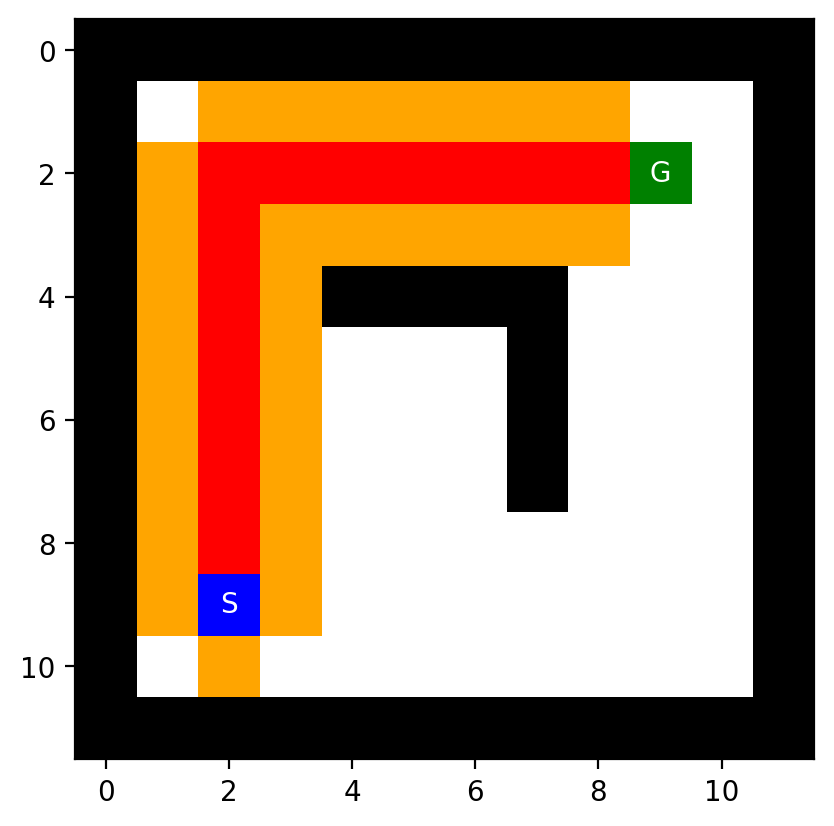



wall_maze.txt
A*


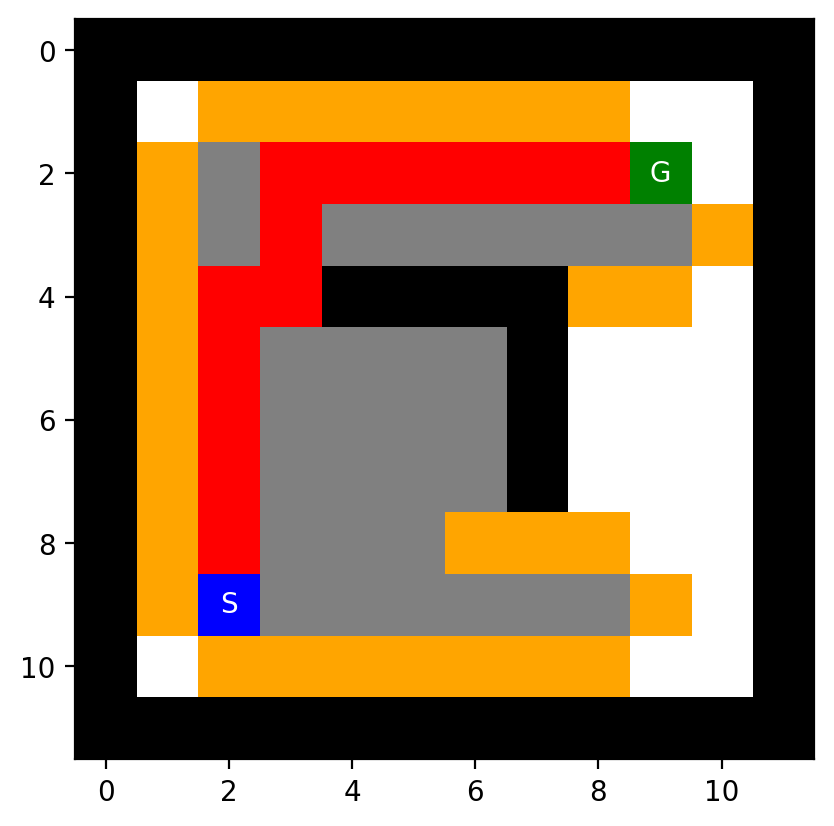



loops_maze.txt
BFS


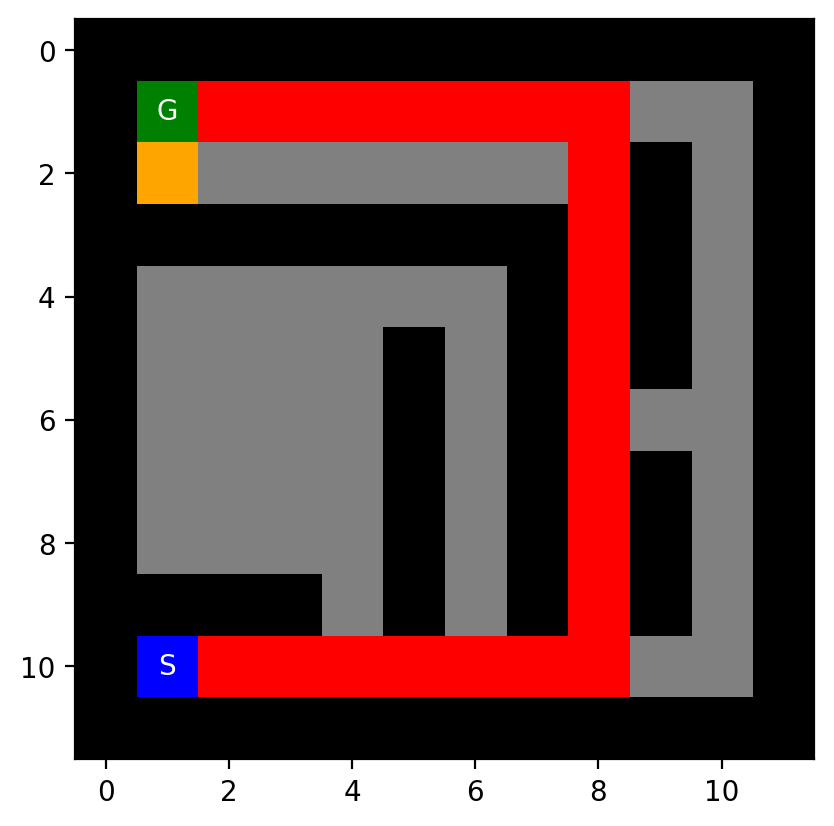



loops_maze.txt
DFS


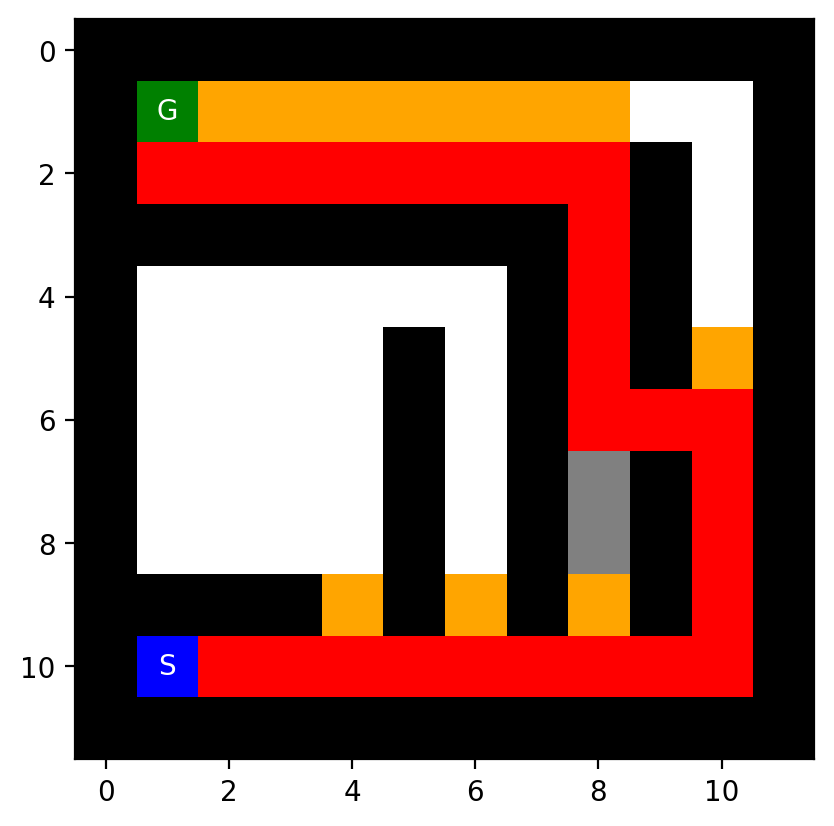



loops_maze.txt
GBS


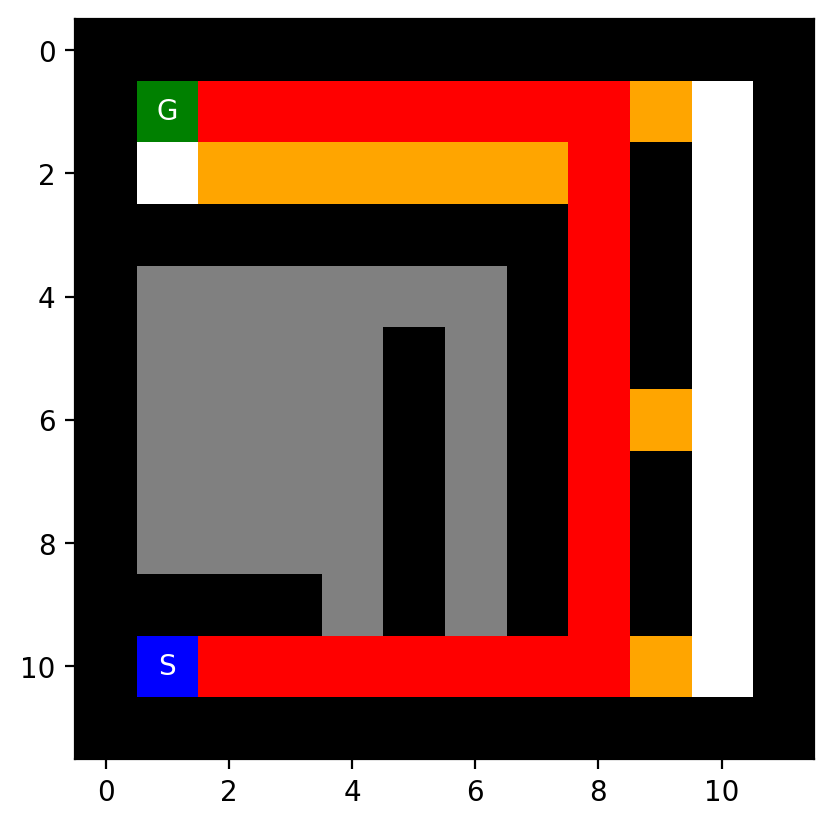



loops_maze.txt
A*


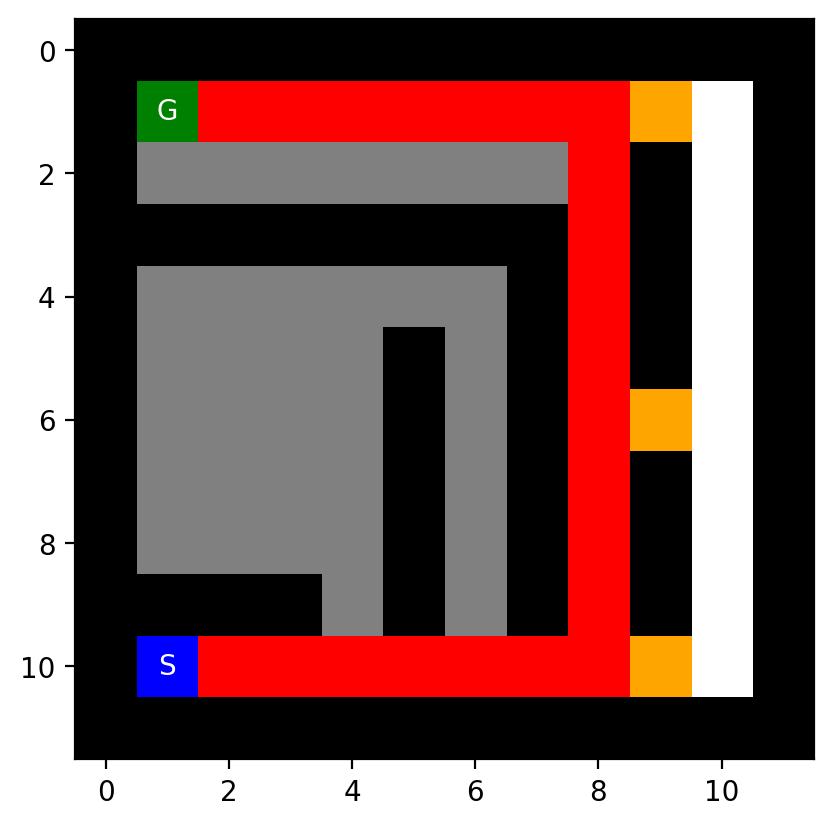



empty_maze.txt
BFS


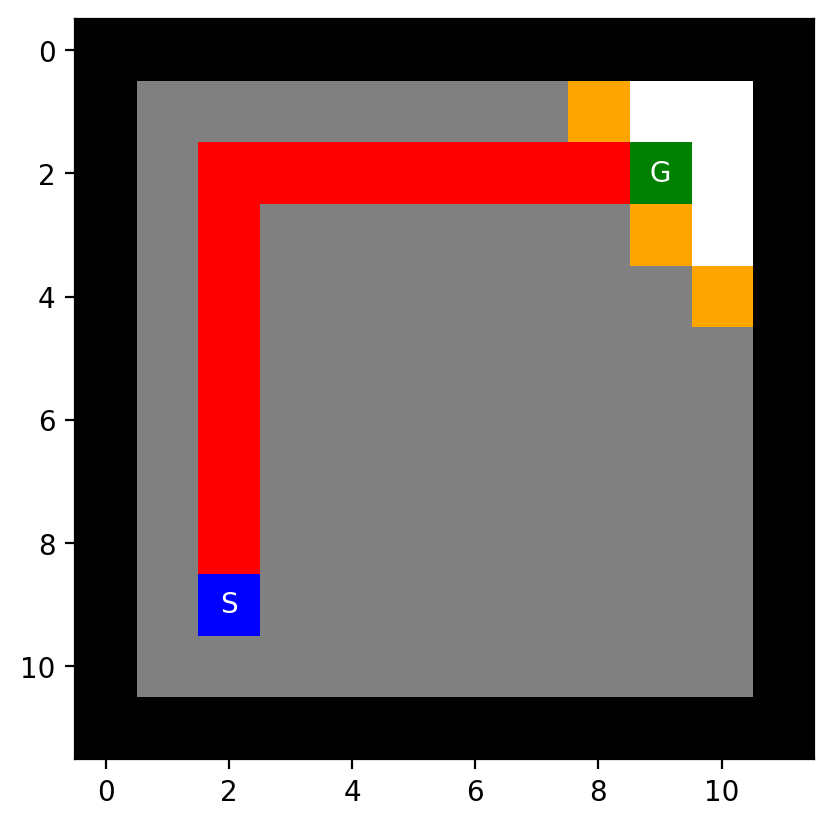



empty_maze.txt
DFS


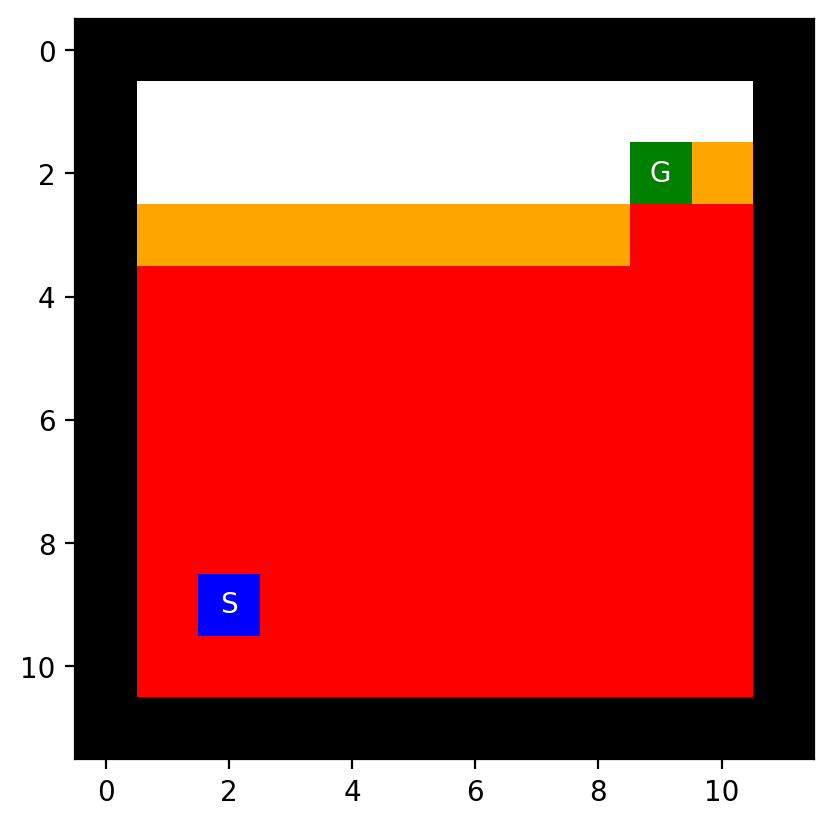



empty_maze.txt
GBS


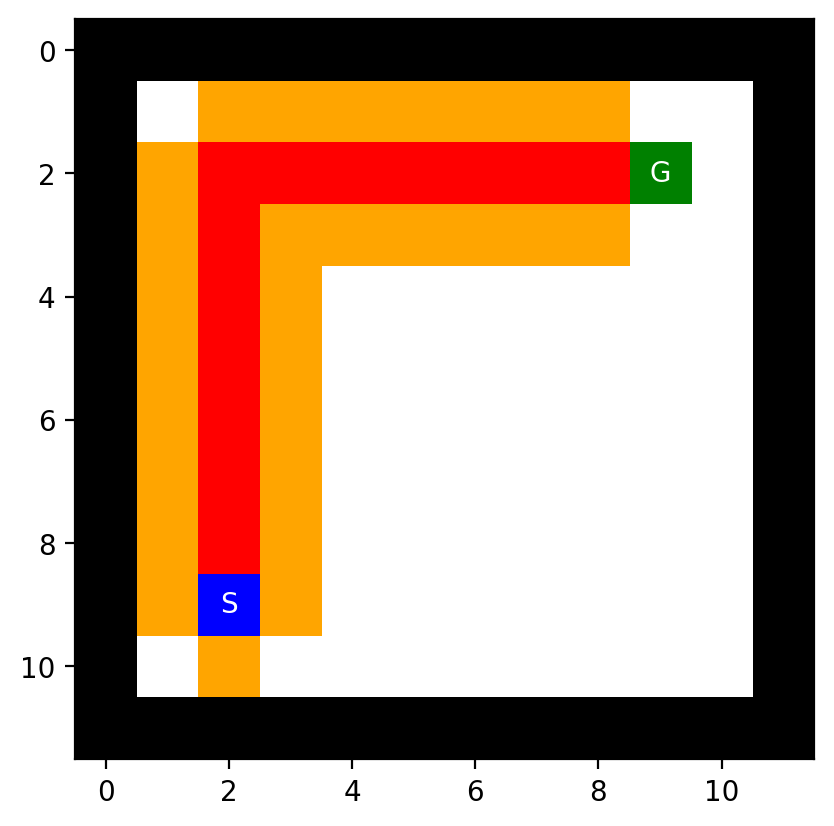



empty_maze.txt
A*


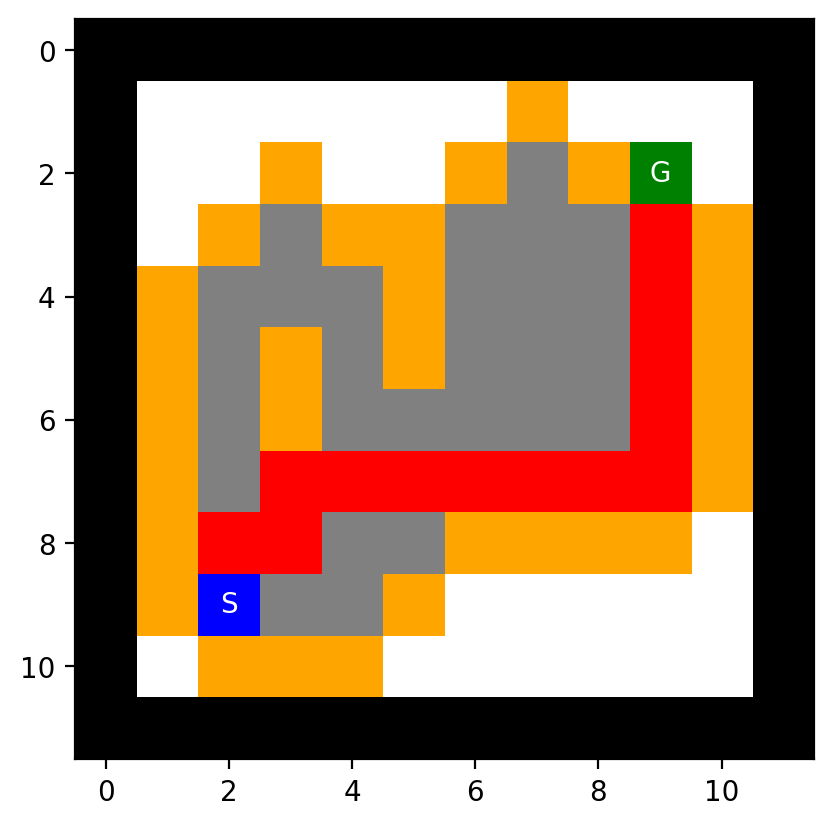



empty_2_maze.txt
BFS


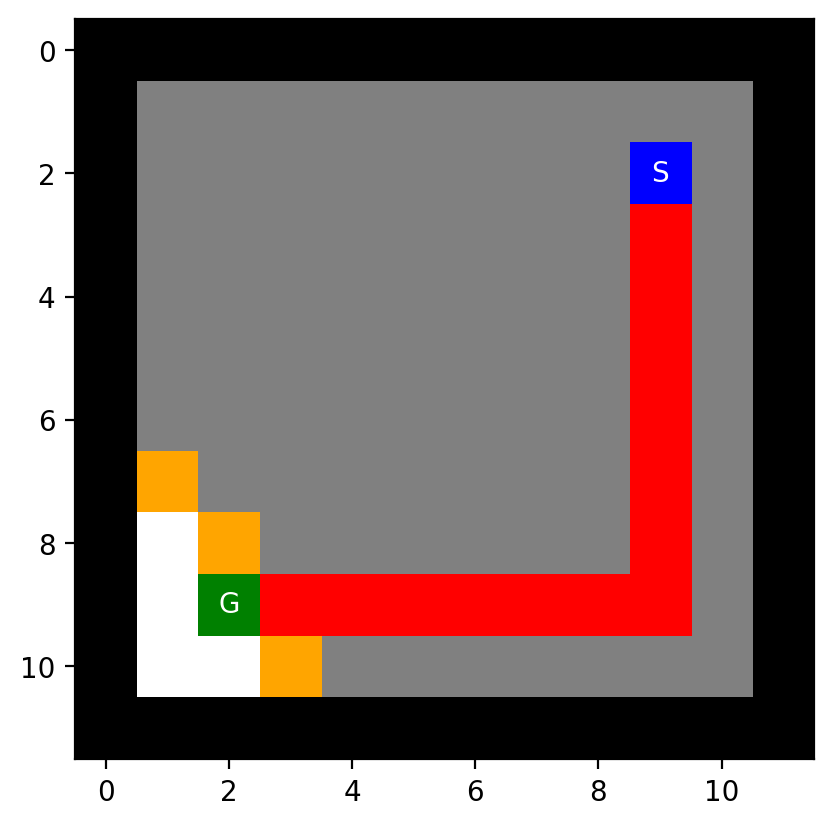



empty_2_maze.txt
DFS


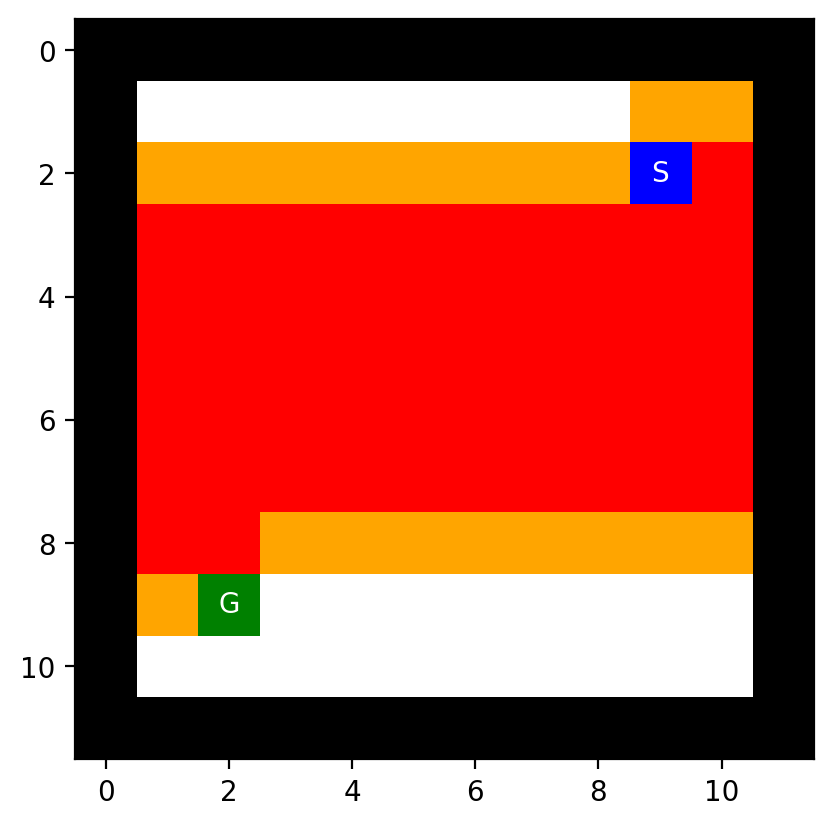



empty_2_maze.txt
GBS


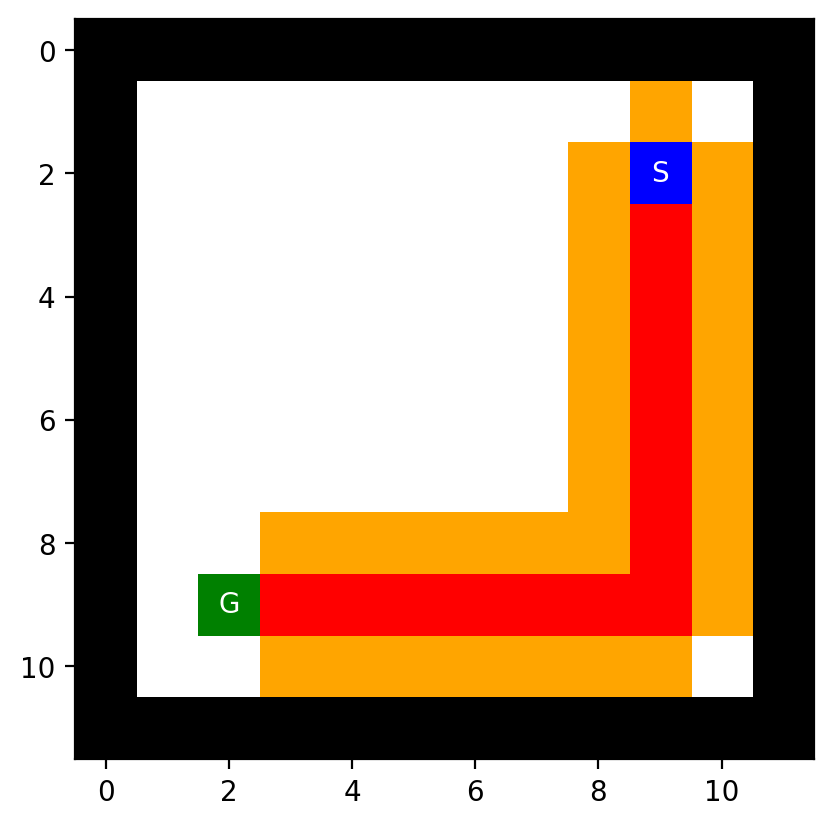



empty_2_maze.txt
A*


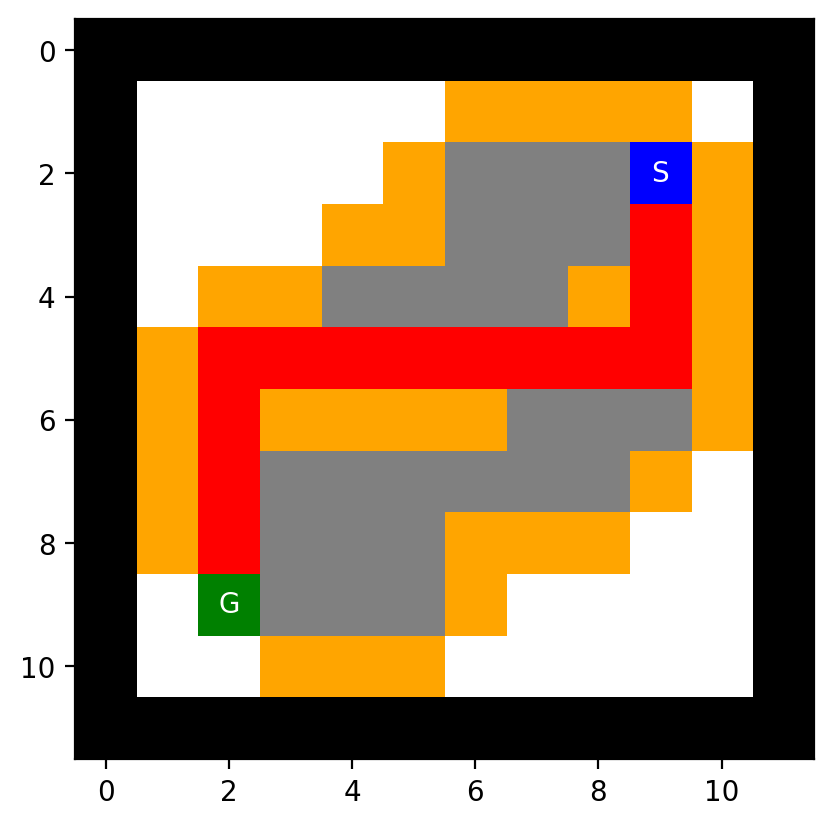

In [50]:
maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
algorithms = [(breadth_first_search, "BFS"), (depth_first_search, "DFS"), (greedy_best_first_search, "GBS"), (a_star_search, "A*")]
mazes = []
headers = "| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |\n|-----------|-----------|----------------|----------------|---------------|-------------------|"
data = {"BFS": [], "DFS": [], "GBS": [], "A*": []}

# iterate over all maze files
for m in maze_files:
  # open and read file
  with open(m, "r") as f:
    maze_str = f.read()

  # part of table generation
  # print(m)
  # print()
  # print(headers)

  # iterate over all algorithms
  for a, b in algorithms:
    # exempt DFS from running on the open maze because it will infinitely run
    if b == "DFS" and m == "open_maze.txt":
      # parse and add maze to maze list
      maze = mh.parse_maze(maze_str)
      mazes.append(maze)

      # add zeros for table variables
      data[b].append([0, 0, 0, 0, 0])

      # part of table generation
      # print("", b, "N/A*", "N/A*", "N/A*", "N/A*", "N/A*", "", sep="|")

      continue

    # parse the maze and run the algorithm on it
    maze = mh.parse_maze(maze_str)
    d = a(maze)

    # add maze to maze list
    mazes.append(maze)

    # add table variables to the corresponding algorithm in data
    data[b].append([d["path_cost"], d["num_expanded"], d["max_depth"], d["max_memory"], d["max_frontier"]])

    # part of table generation
    # print("", b, d["path_cost"], d["num_expanded"], d["max_depth"], d["max_memory"], d["max_frontier"], "", sep="|")

  # part of table generation
  # print("\n")

# for copying and pasting into charts cell
# print(data)

# visualize the solutions to the mazes by all algorithms
for i in range(len(mazes)):
  print(maze_files[i//4])
  print(algorithms[i%4][1])
  mh.show_maze(mazes[i])
  print("\n")

small_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|19|90|19|91|8|
|DFS|37|37|37|7|7|
|GBS|29|40|30|44|5|
|A*|19|53|20|59|8|


medium_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|68|267|68|269|8|
|DFS|130|146|130|9|9|
|GBS|74|79|75|82|4|
|A*|68|222|69|228|8|


large_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|210|617|210|620|8|
|DFS|210|387|223|39|39|
|GBS|210|468|211|487|20|
|A*|210|550|211|557|11|


open_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|54|679|54|682|25|
|DFS|N/A*|N/A*|N/A*|N/A*|N/A*|
|GBS|68|90|69|155|66|
|A*|54|243|55|340|102|


wall_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|14|85|14|88|11|
|DFS|44|44|44|36|36|
|GBS|14|15|15|43|29|
|A*|14|44|15|73|30|


loops_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|23|70|23|71|8|
|DFS|27|30|27|12|12|
|GBS|23|52|24|61|10|
|A*|23|59|24|62|7|


empty_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|14|92|14|95|12|
|DFS|72|72|72|65|65|
|GBS|14|15|15|43|29|
|A*|14|42|15|72|34|


empty_2_maze.txt

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
|BFS|14|92|14|95|12|
|DFS|54|54|54|59|59|
|GBS|14|15|15|43|29|
|A*|14|40|15|71|32|

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

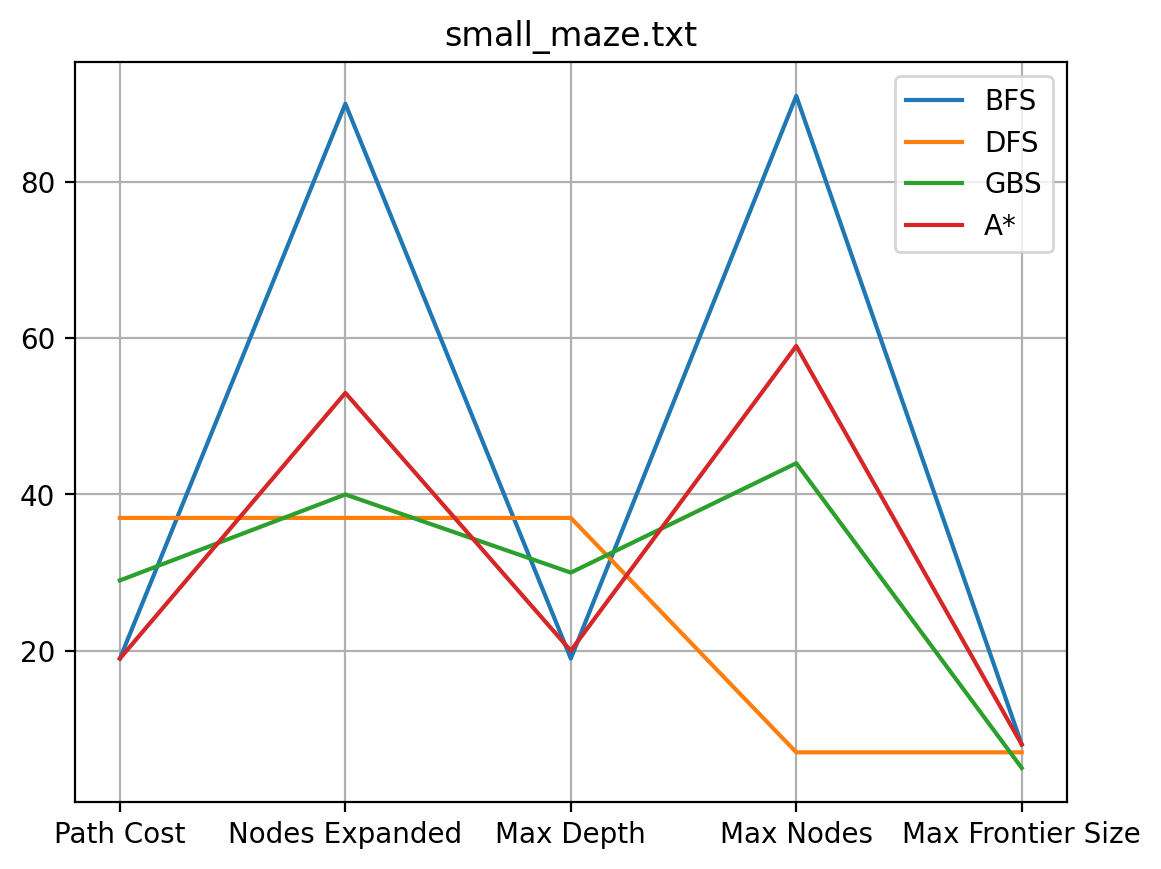

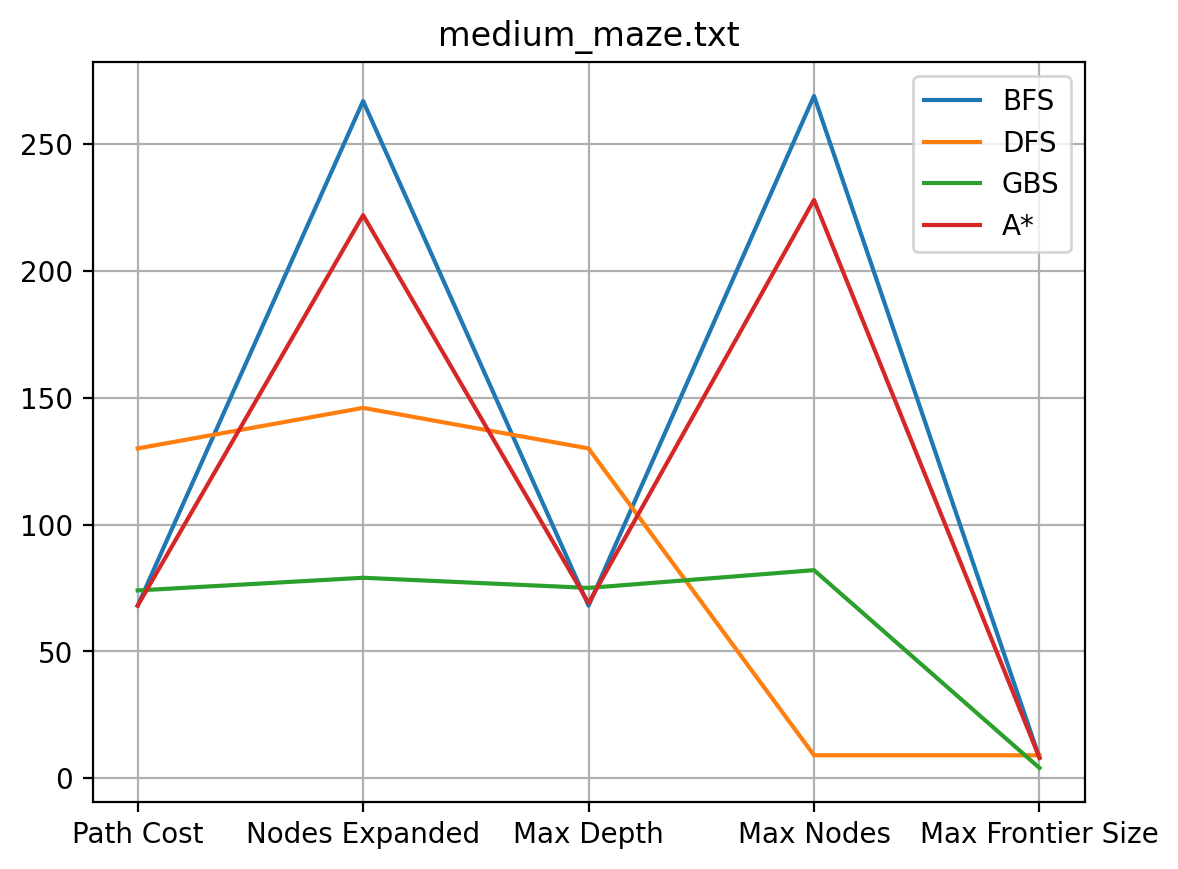

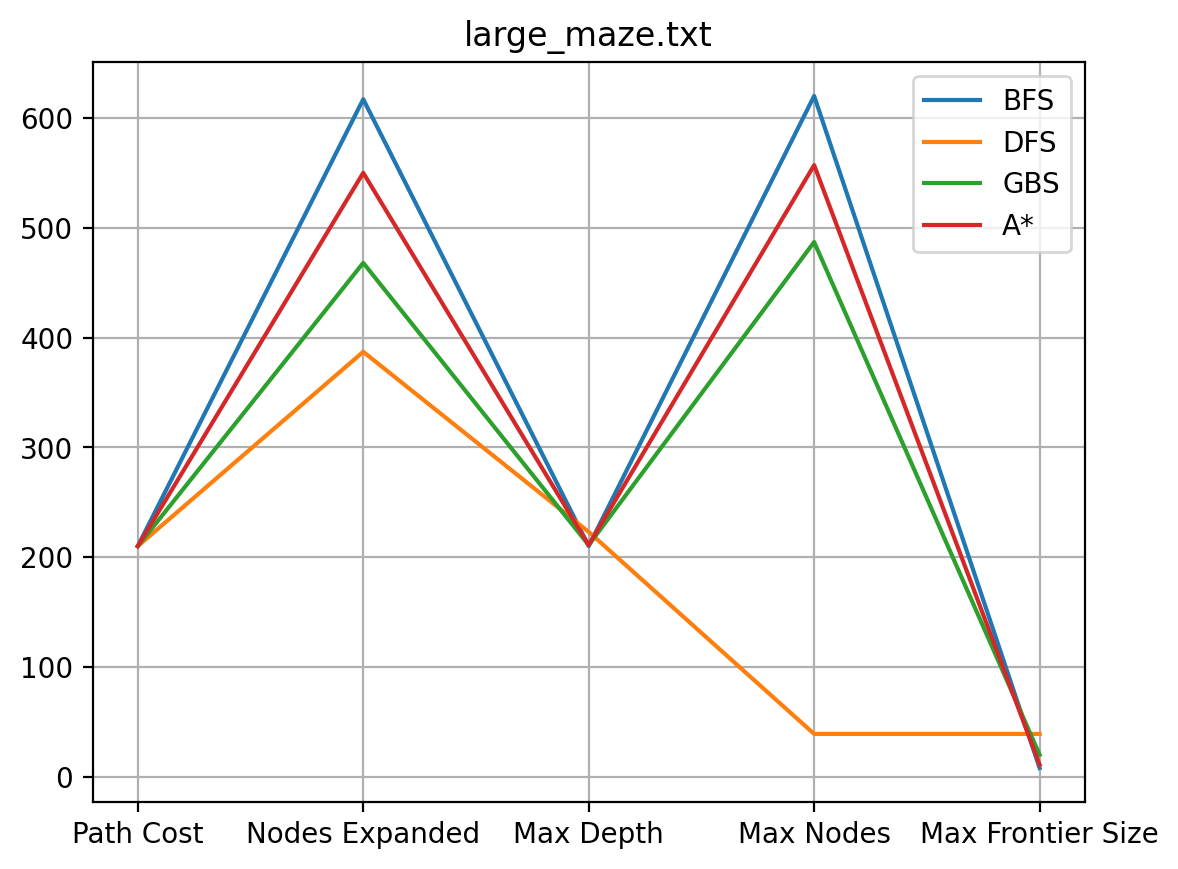

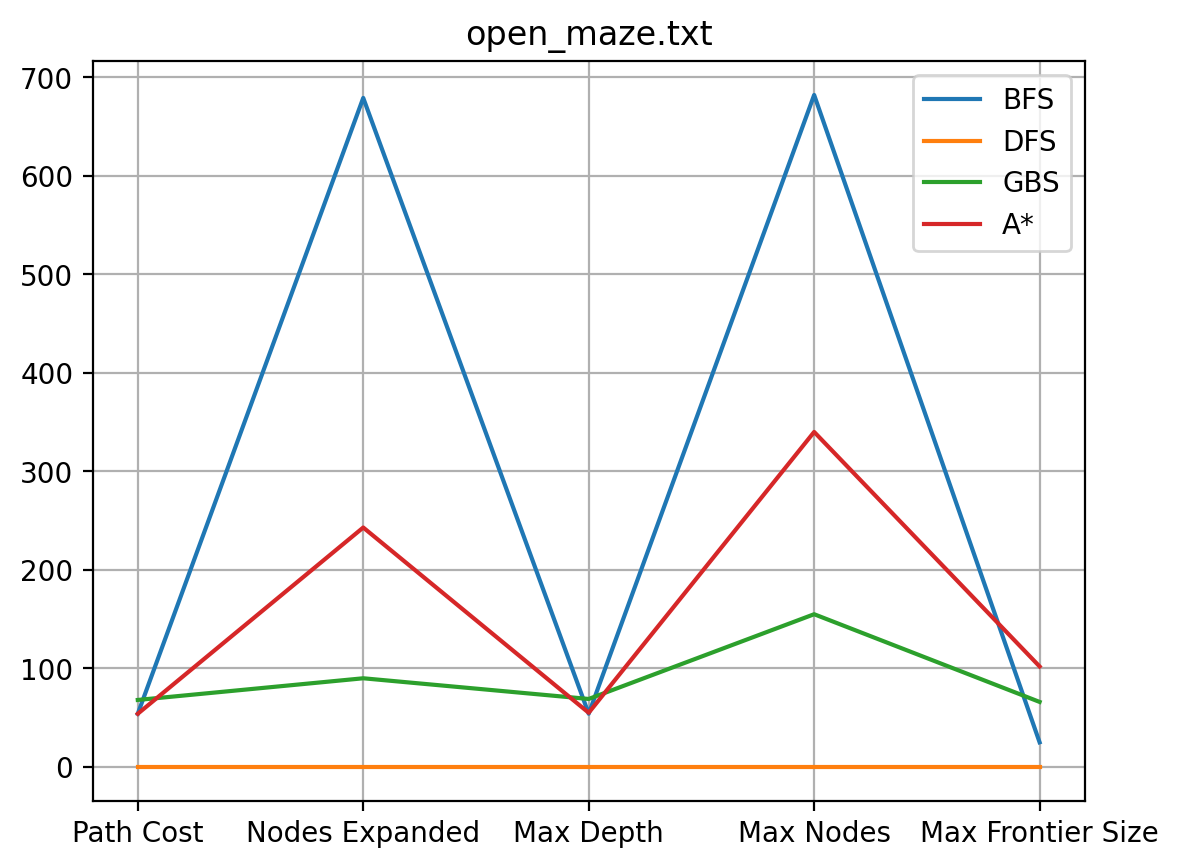

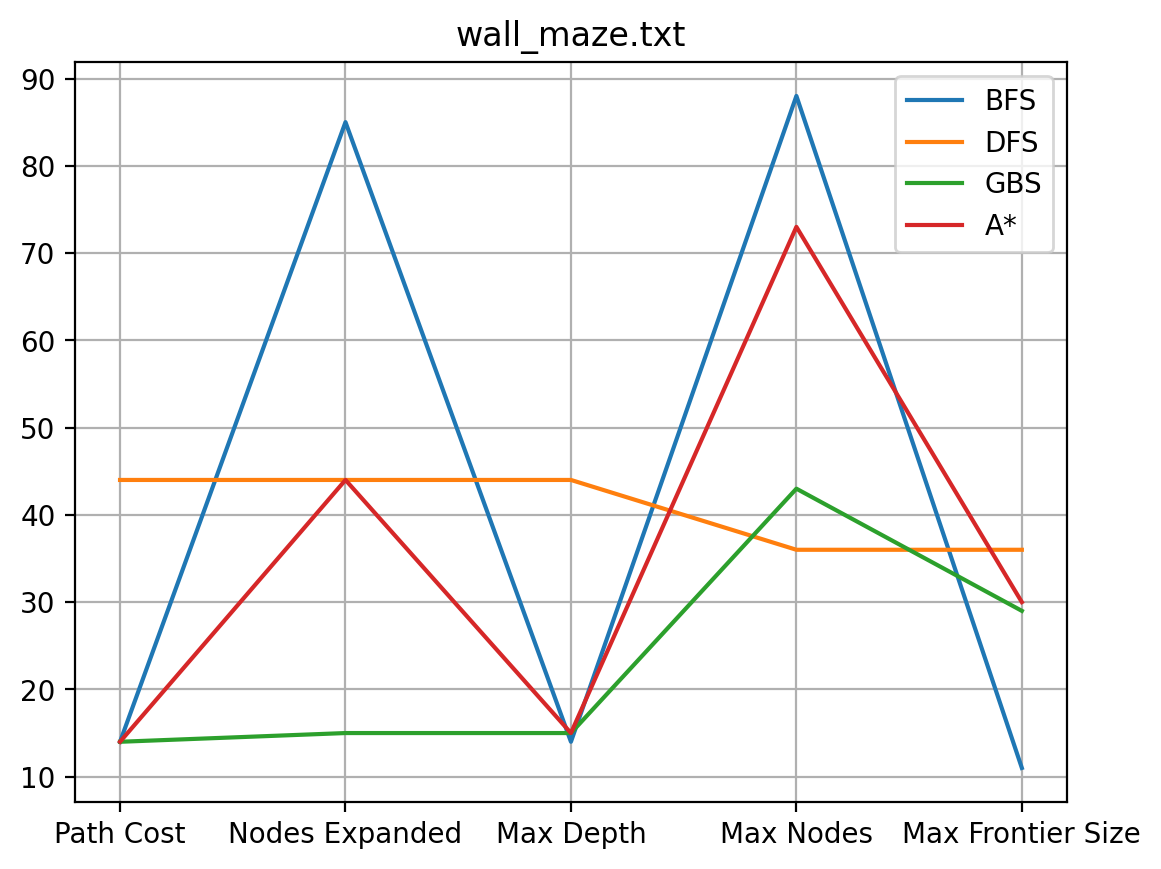

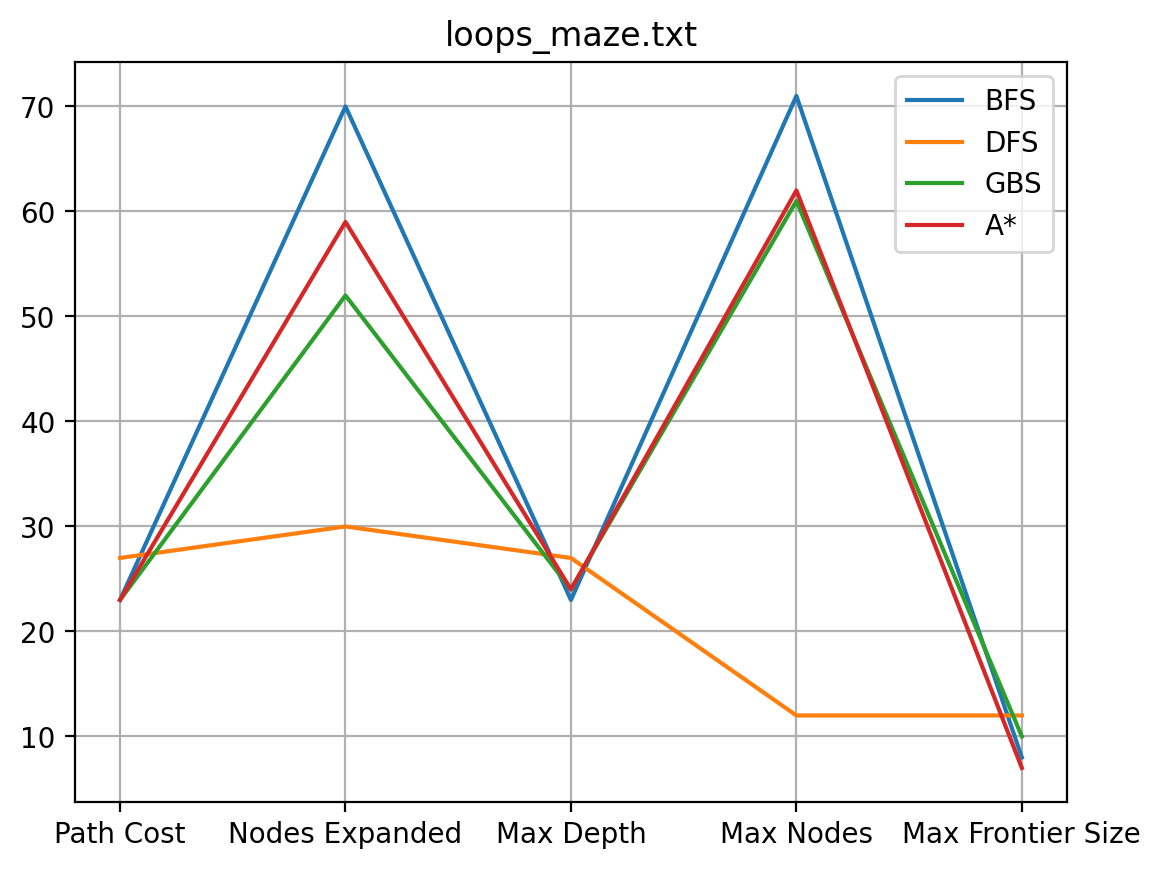

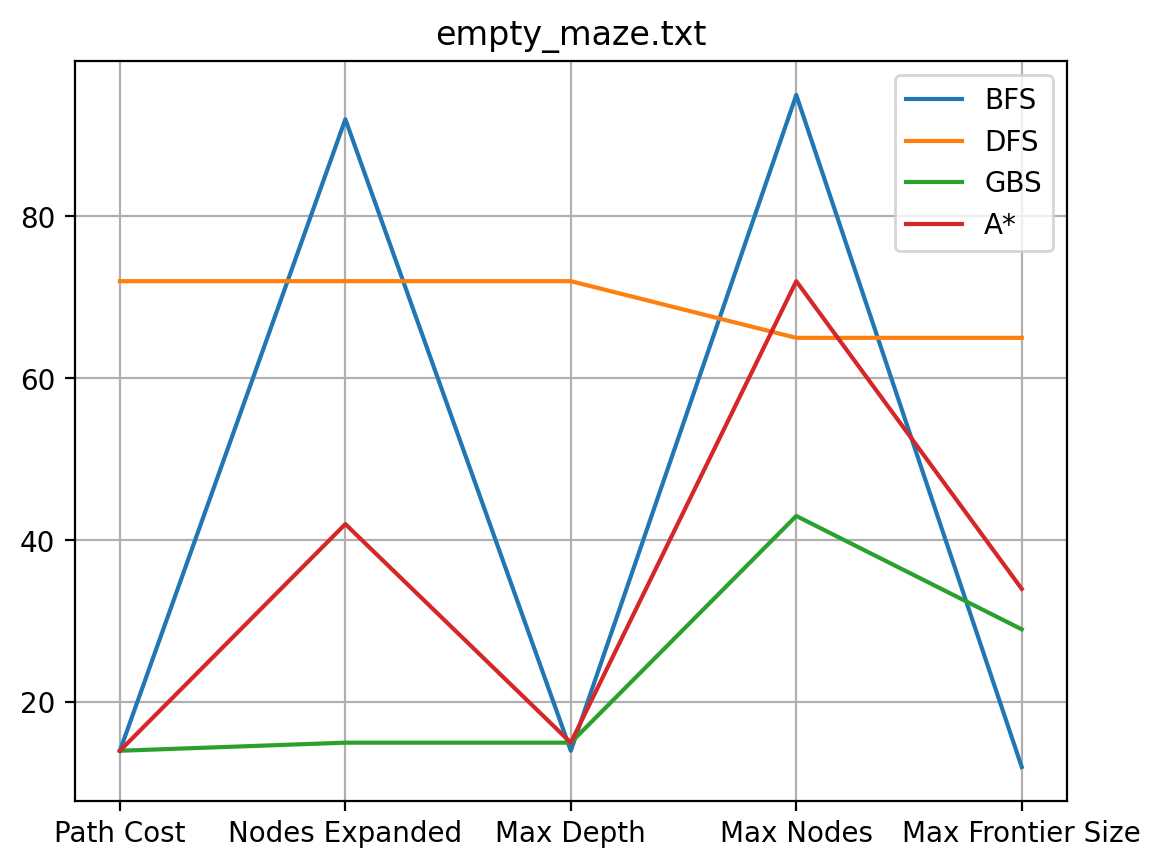

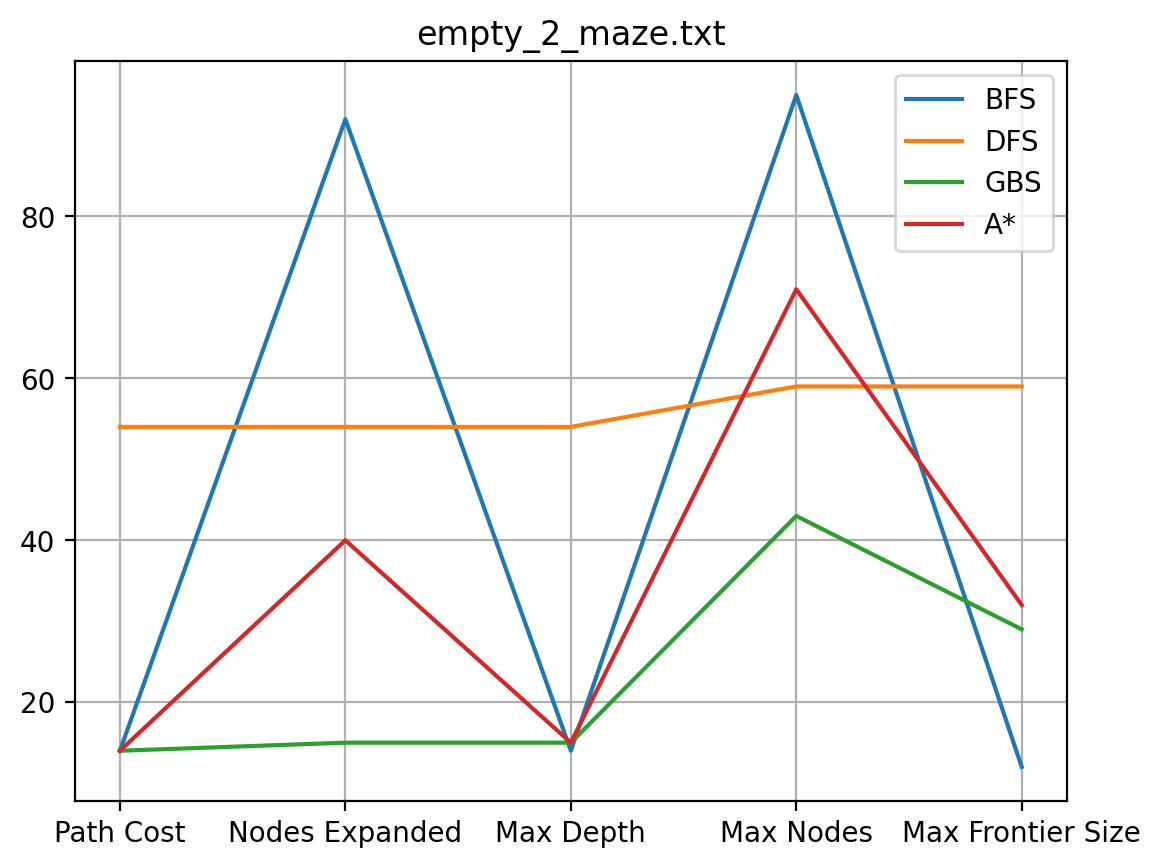

In [51]:
# Run the below code to see the graphs for each maze file.
import matplotlib.pyplot as plt

maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
variables = ["Path Cost", "Nodes Expanded", "Max Depth", "Max Nodes", "Max Frontier Size"]
algorithms = ["BFS", "DFS", "GBS", "A*"]
data = {'BFS': [[19, 90, 19, 91, 8], [68, 267, 68, 269, 8], [210, 617, 210, 620, 8], [54, 679, 54, 682, 25], [14, 85, 14, 88, 11], [23, 70, 23, 71, 8], [14, 92, 14, 95, 12], [14, 92, 14, 95, 12]], 'DFS': [[37, 37, 37, 7, 7], [130, 146, 130, 9, 9], [210, 387, 223, 39, 39], [0, 0, 0, 0, 0], [44, 44, 44, 36, 36], [27, 30, 27, 12, 12], [72, 72, 72, 65, 65], [54, 54, 54, 59, 59]], 'GBS': [[29, 40, 30, 44, 5], [74, 79, 75, 82, 4], [210, 468, 211, 487, 20], [68, 90, 69, 155, 66], [14, 15, 15, 43, 29], [23, 52, 24, 61, 10], [14, 15, 15, 43, 29], [14, 15, 15, 43, 29]], 'A*': [[19, 53, 20, 59, 8], [68, 222, 69, 228, 8], [210, 550, 211, 557, 11], [54, 243, 55, 340, 102], [14, 44, 15, 73, 30], [23, 59, 24, 62, 7], [14, 42, 15, 72, 34], [14, 40, 15, 71, 32]]}

for i in range(len(maze_files)):
  plt.figure()
  plt.plot(variables, data["BFS"][i])
  plt.plot(variables, data["DFS"][i])
  plt.plot(variables, data["GBS"][i])
  plt.plot(variables, data["A*"][i])
  plt.title(maze_files[i])
  plt.legend(algorithms)
  plt.grid("on")

Discuss the most important lessons you have learned from implementing the different search strategies.

In [52]:
# I have learned that...
# The implementations of all four algorithms are very similar
# DFS without a reached data structure performs very poorly on graph searches with cycles
# DFS with cycle checking may not prevent all cycles
# BFS expands and stores the most number of nodes out of the algorithms tested
# GBS tends to be lower than BFS and A* in all five variables tested, sometimes to a great degree
# A* tends to be lower than BFS overall in the five variables tested

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.